# Import & Setup

In [1]:
# !pip install --upgrade numpy matplotlib seaborn pandas scipy scikit-learn statsmodels plotnine statsforecast

In [1]:
from my_functions.df_exploration import *
from my_functions.tsa.time_series_analysis import *
from my_functions.tsa.multivariate import *

from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from my_functions.tsa.cv_extensions.montecarlo_cv import MonteCarloCV
from my_functions.tsa.metrics import *

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plot_fig_args = {
    'width' : 16 ,
    'height' : 4,
    'dpi' : 100 
    }

plot_seasonal_decompose_fig_args = {
    'width' : 10 ,
    'height' : 7,
    'dpi' : 80 
    }

plot_tsa_fig_args = {
    'width' : 8 ,
    'height' : 5,
    'dpi' : 80 
    }

In [3]:
# Setup the metric
error_name=['SMAPE', 'MAPE', 'MAE', 'RMSE']
error_callback=[symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error]

# Load Data

Le data set contient :
	- 123 lignes et 8 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


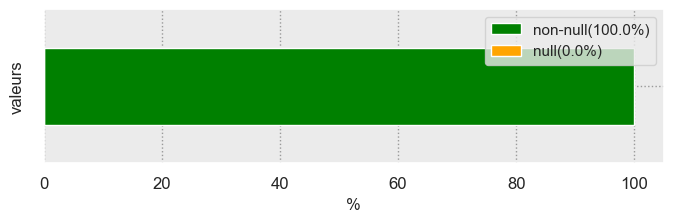

rgnp    pgnp    ulc  gdfco    gdf  gdfim  gdfcf  gdfce
date                                                                
1959-01-01  1606.4  1608.3   47.5   36.9   37.4   26.9   32.3   23.1
1959-04-01  1637.0  1622.2   47.5   37.4   37.5   27.0   32.2   23.4
1959-07-01  1629.5  1636.2   48.7   37.6   37.6   27.1   32.4   23.4
1959-10-01  1643.4  1650.3   48.8   37.7   37.8   27.1   32.5   23.8
1960-01-01  1671.6  1664.6   49.1   37.8   37.8   27.2   32.4   23.8
...            ...     ...    ...    ...    ...    ...    ...    ...
1988-07-01  4042.7  3971.9  179.6  131.5  124.9  106.2  123.5   92.8
1988-10-01  4069.4  3995.8  181.3  133.3  126.2  107.3  124.9   92.9
1989-01-01  4106.8  4019.9  184.1  134.8  127.7  109.5  126.6   94.0
1989-04-01  4132.5  4044.1  186.1  134.8  129.3  111.1  129.0  100.6
1989-07-01  4162.9  4068.4  187.4  137.2  130.2  109.8  129.9   98.2

[123 rows x 8 columns]

In [5]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

verifier_taille(df)
df

# EDA

## Basic Plot

<Axes: xlabel='date'>

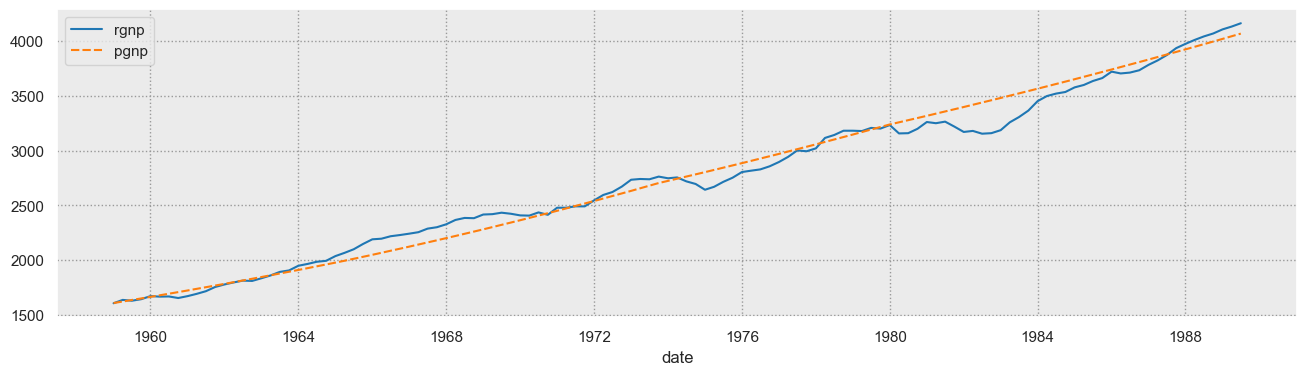

In [6]:
fig, ax = plt.subplots( dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']))
sns.lineplot(df[['rgnp', 'pgnp']],ax=ax)

<Axes: xlabel='date'>

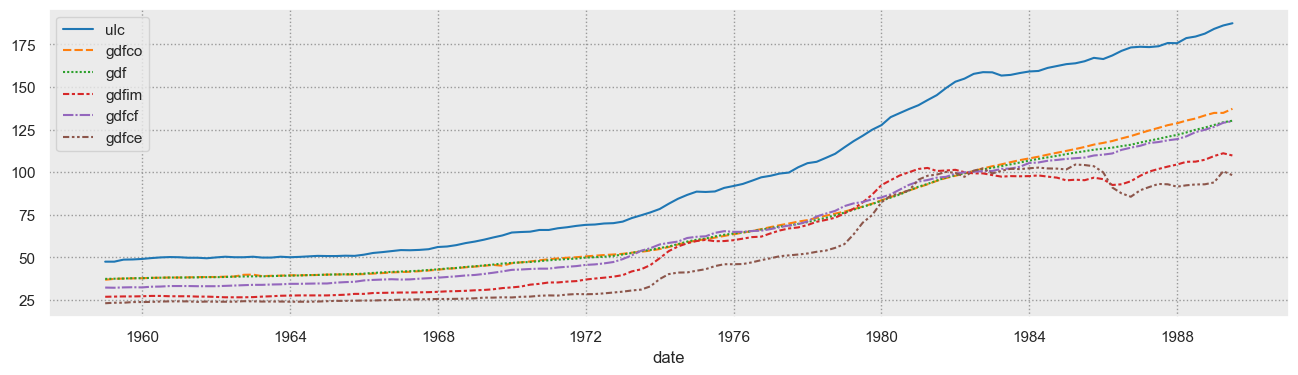

In [7]:
fig, ax = plt.subplots( dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']))
sns.lineplot(df.drop(columns=['rgnp', 'pgnp']), ax=ax)

## Granger Causality Test

In [9]:
grangers_causation_matrix(df, variables = df.columns)

rgnp_x  pgnp_x   ulc_x  gdfco_x   gdf_x  gdfim_x  gdfcf_x  gdfce_x
rgnp_y   1.0000  0.0003  0.0001   0.0212  0.0014   0.0620   0.0001   0.0071
pgnp_y   0.0000  1.0000  0.0000   0.0000  0.0000   0.0000   0.0000   0.0000
ulc_y    0.0000  0.0000  1.0000   0.0002  0.0000   0.0000   0.0000   0.0041
gdfco_y  0.0000  0.0000  0.0000   1.0000  0.0000   0.0000   0.0000   0.0000
gdf_y    0.0000  0.0000  0.0000   0.0000  1.0000   0.0000   0.0000   0.0000
gdfim_y  0.0011  0.0067  0.0014   0.0083  0.0011   1.0000   0.0004   0.0000
gdfcf_y  0.0000  0.0000  0.0008   0.0008  0.0000   0.0038   1.0000   0.0009
gdfce_y  0.0025  0.0485  0.0000   0.0002  0.0000   0.0000   0.0000   1.0000

## Cointegration Test

In [10]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


## Stationarity Study

### Stationarity Test

In [11]:
# ncols=2
# nrows=len(df.columns)//ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']*nrows))
# for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
#     lineplot(df[col], '', None, col, plot_fig_args=plot_fig_args, ax=ax)

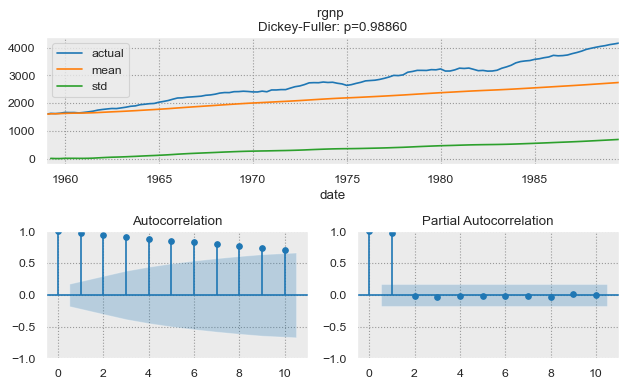

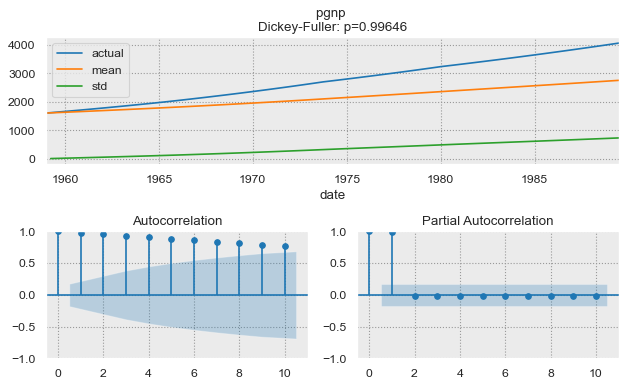

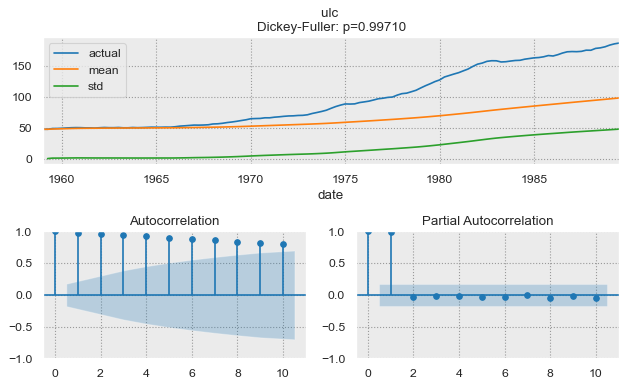

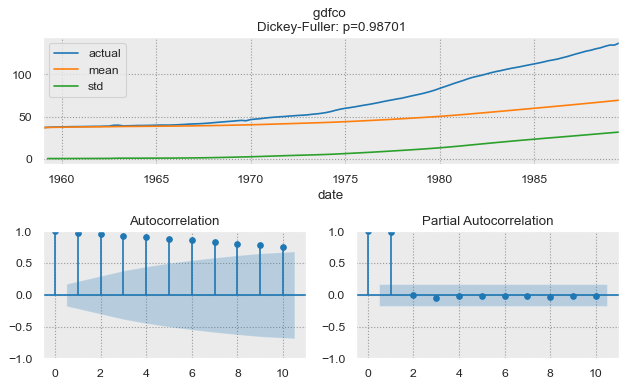

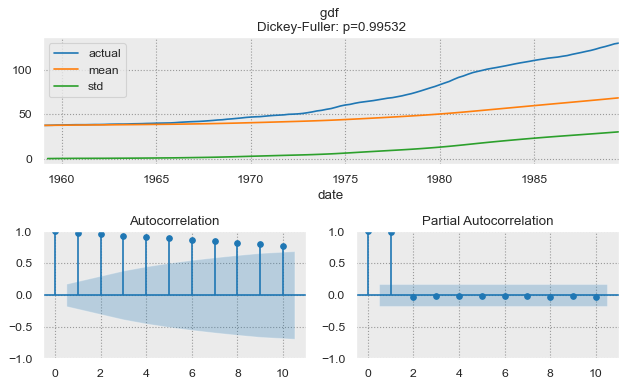

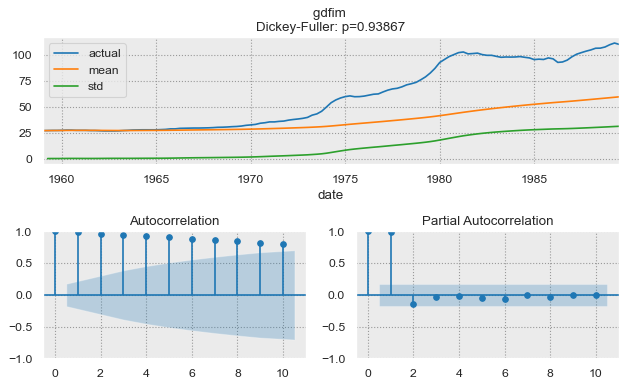

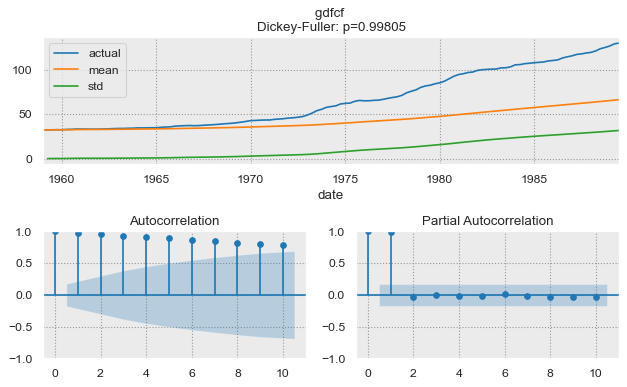

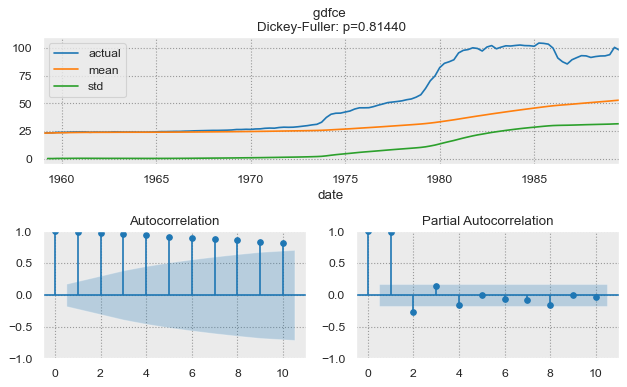

In [12]:
# ADF Test on each column
for name, column in df.iteritems():
    plot_tsa(column, name, 10, plot_tsa_fig_args)

### 1st Differencing

In [13]:
# 1st difference
df_differenced = df.diff().dropna()

### Stationarity Test after 1st Differencing

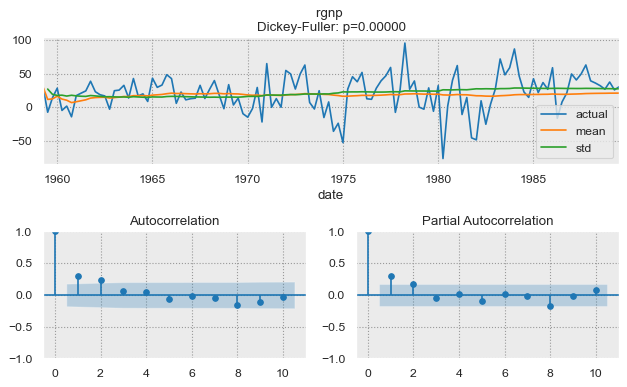

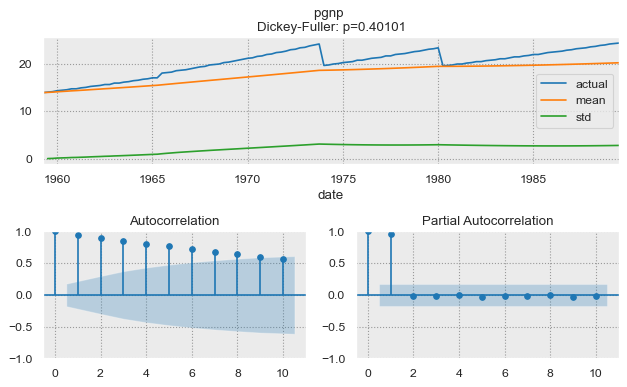

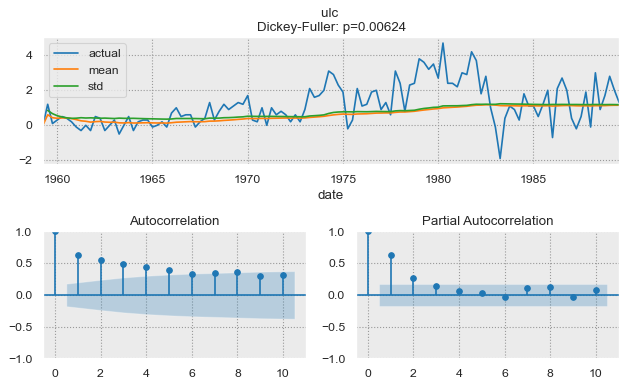

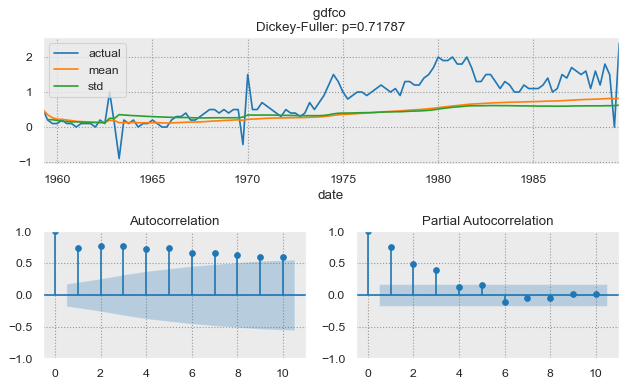

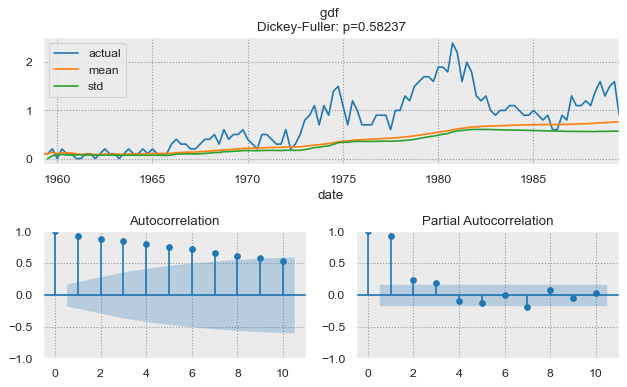

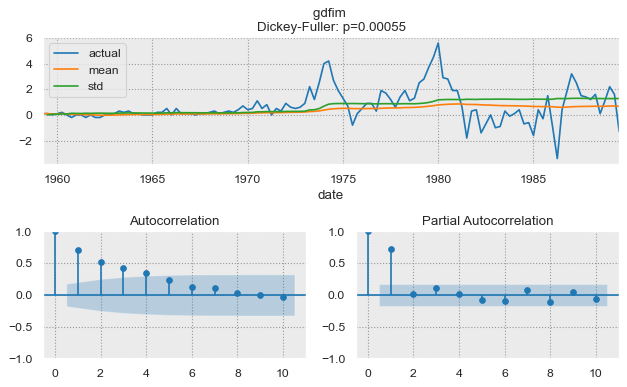

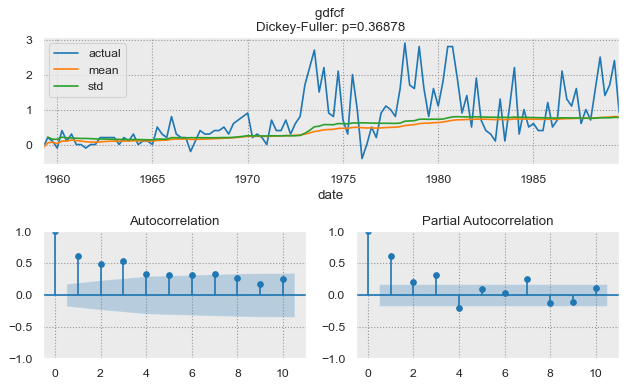

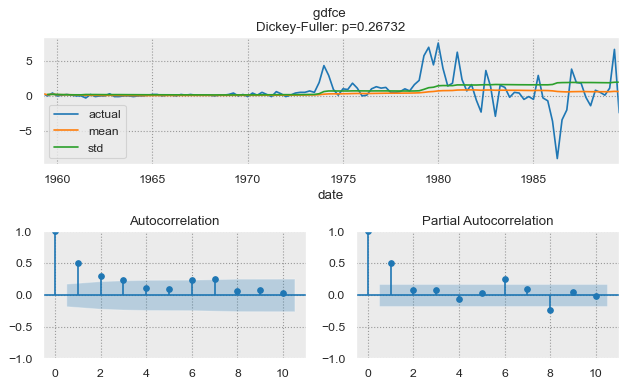

In [14]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    plot_tsa(column, name, 10, plot_tsa_fig_args)

### 2nd Differencing

In [15]:
# 2nd difference
df_differenced2 = df_differenced.diff().dropna()

### Stationarity Test after 2nd Differencing

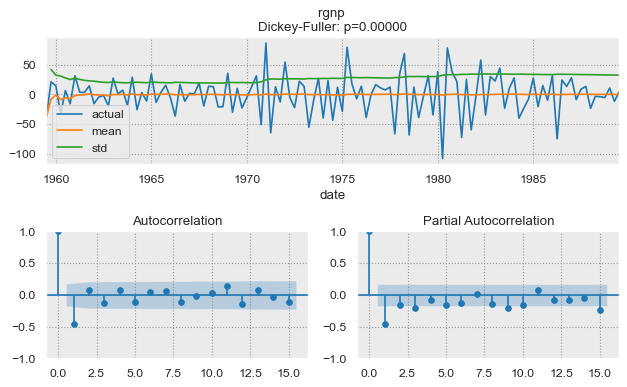

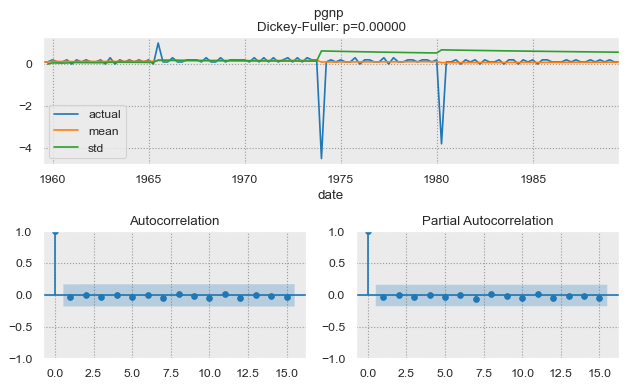

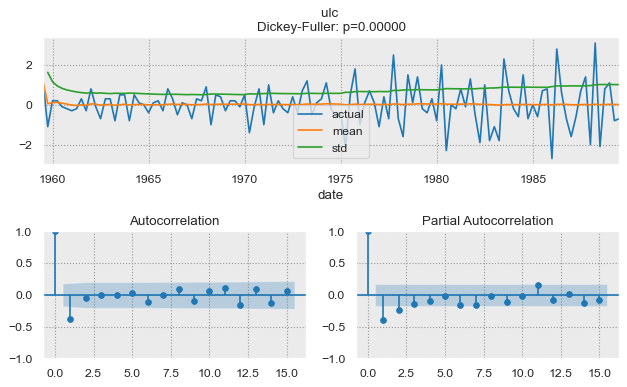

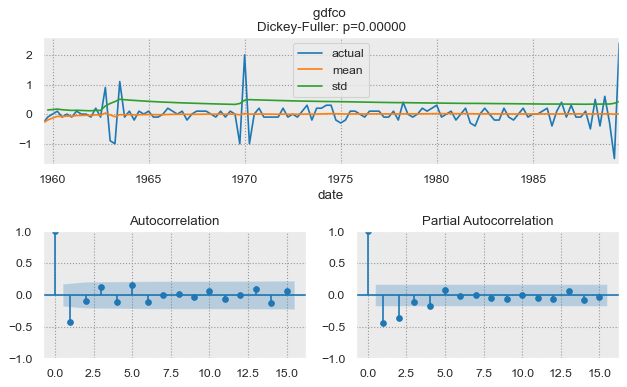

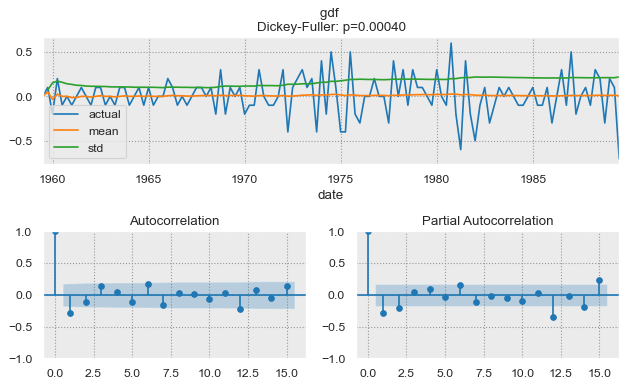

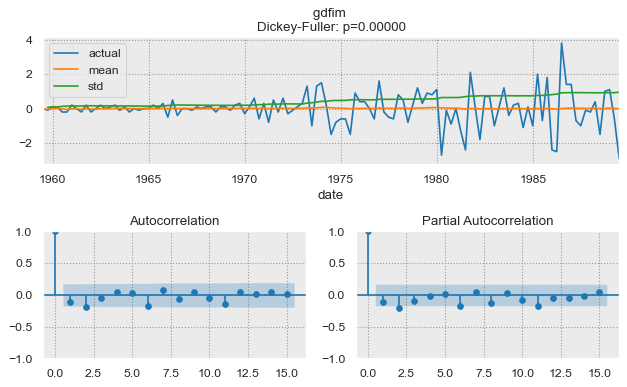

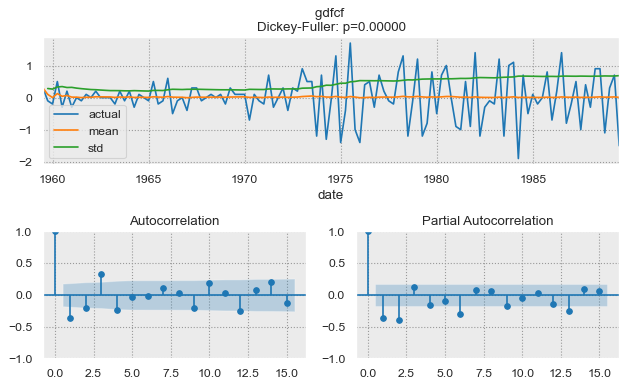

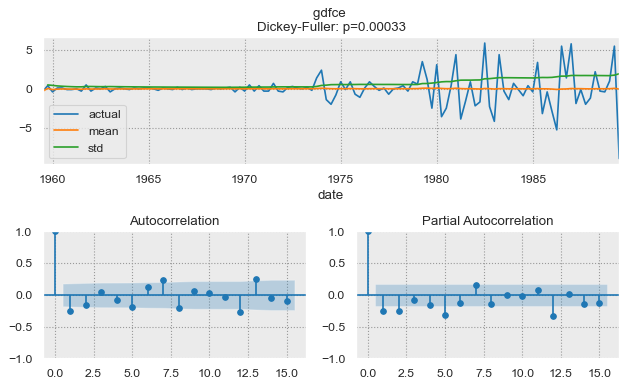

In [16]:
# ADF Test on each column
for name, column in df_differenced2.iteritems():
    plot_tsa(column, name, 15, plot_tsa_fig_args)

# Stats Modeling

In [17]:
in_sample_size = 10
out_sample_size = 5
df_train, df_test = df_differenced2[:-in_sample_size], df[-in_sample_size:]

# Check size
print(df_train.shape)
print(df_test.shape)

(111, 8)
(10, 8)


## VAR

### Select the Order (P) of VAR model

In [18]:
model = VAR(df_train)

for i in list(range(0,in_sample_size+1)):
    result = model.fit(i)
    print('Lag Order =', i, '-> AIC :', result.aic, 'BIC :', result.bic, 'FPE :', result.fpe, 'HQIC:', result.hqic)

Lag Order = 0 -> AIC : -0.9610883940918956 BIC : -0.7658069381414572 FPE : 0.3824778659395453 HQIC: -0.8818684794094933
Lag Order = 1 -> AIC : -1.5659089395071053 BIC : 0.20167820901156697 FPE : 0.20951162782074265 HQIC: -0.8489660477499816
Lag Order = 2 -> AIC : -1.8820455106082434 BIC : 1.475966525934541 FPE : 0.15543747543980052 HQIC: -0.5202489728180102
Lag Order = 3 -> AIC : -2.084592886084412 BIC : 2.8823167937752556 FPE : 0.1331567296157059 HQIC: -0.07069141689193348
Lag Order = 4 -> AIC : -2.315900134267194 BIC : 4.278742971321059 FPE : 0.11650035738735681 HQIC: 0.3574804916958776
Lag Order = 5 -> AIC : -2.1085285116368206 BIC : 6.133056609766557 FPE : 0.170529799252589 HQIC: 1.2318307846648207
Lag Order = 6 -> AIC : -2.8078576431542066 BIC : 7.10026099743388 FPE : 0.11284760301534603 HQIC: 1.2071074952693444
Lag Order = 7 -> AIC : -3.2722226051391097 BIC : 8.32241441417306 FPE : 0.11176025658547252 HQIC: 1.4251055939988202
Lag Order = 8 -> AIC : -3.984427037375127 BIC : 9.3171

In [19]:
x = model.select_order(in_sample_size+1)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

### Fit the model

In [20]:
model_fitted = model.fit(4)

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [21]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

rgnp : 2.1
pgnp : 2.02
ulc : 2.2
gdfco : 2.07
gdf : 2.23
gdfim : 1.97
gdfcf : 2.22
gdfce : 2.08


### Forecast

In [22]:
# Get the lag order
lag_order = model_fitted.k_ar
print('lag_order :', lag_order) 

# Input data for forecasting
forecast_input = df_differenced2.values[-lag_order:]
forecast_input

lag_order : 4


array([[ -5.3,   0.1,   0.8,   0.6,  -0.3,   1. ,  -1.1,  -0.4],
       [ 10.7,   0.2,   1.1,  -0.3,   0.2,   1.1,   0.3,   1. ],
       [-11.7,   0.1,  -0.8,  -1.5,   0.1,  -0.6,   0.7,   5.5],
       [  4.7,   0.1,  -0.7,   2.4,  -0.7,  -2.9,  -1.5,  -9. ]])

In [23]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=in_sample_size+out_sample_size)
fc[:,0]
df_forecast = pd.DataFrame(fc, columns=df.columns + '_2d')
df_forecast[:5]

rgnp_2d   pgnp_2d    ulc_2d  gdfco_2d    gdf_2d  gdfim_2d  gdfcf_2d  \
0   -1.747094  0.092228 -0.076057 -1.054621  0.373891 -0.355345  0.646469   
1   36.760787  0.425550 -0.665495 -0.497868 -0.630753  1.825109  0.462526   
2  -72.841167 -0.063114  1.253456 -0.110653 -0.078365 -1.536871 -1.096963   
3  118.962445  0.600948 -1.828920  0.231827  0.450220  0.285031  0.992087   
4  -60.224155  0.373796  1.676138  0.526648  0.096642  0.856531  0.386274   

   gdfce_2d  
0 -2.116247  
1  1.999451  
2 -1.410752  
3  3.039244  
4  0.889892

In [24]:
# Reverse the differencing
df_results = invert_transformation(df[-(in_sample_size):], df_forecast, second_diff=True)        
df_results.loc[:5, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

rgnp_forecast  pgnp_forecast  ulc_forecast  gdfco_forecast  gdf_forecast  \
0    4191.552906    4092.792228    188.623943      138.545379    131.473891   
1    4256.966599    4117.610005    189.182390      139.392889    132.117030   
2    4249.539125    4142.364669    190.994293      140.129746    132.681804   
3    4361.074096    4167.720280    190.977277      141.098431    133.696798   
4    4412.384912    4193.449688    192.636398      142.593763    134.808434   
5    4485.857837    4219.523486    193.411546      143.945664    135.643557   

   gdfim_forecast  gdfcf_forecast  gdfce_forecast  
0      108.144655      131.446469       93.683753  
1      108.314418      133.455464       91.166957  
2      106.947311      134.367497       87.239410  
3      105.865234      136.271617       86.351106  
4      105.639689      138.562010       86.352696  
5      106.009432      139.700131       84.170045

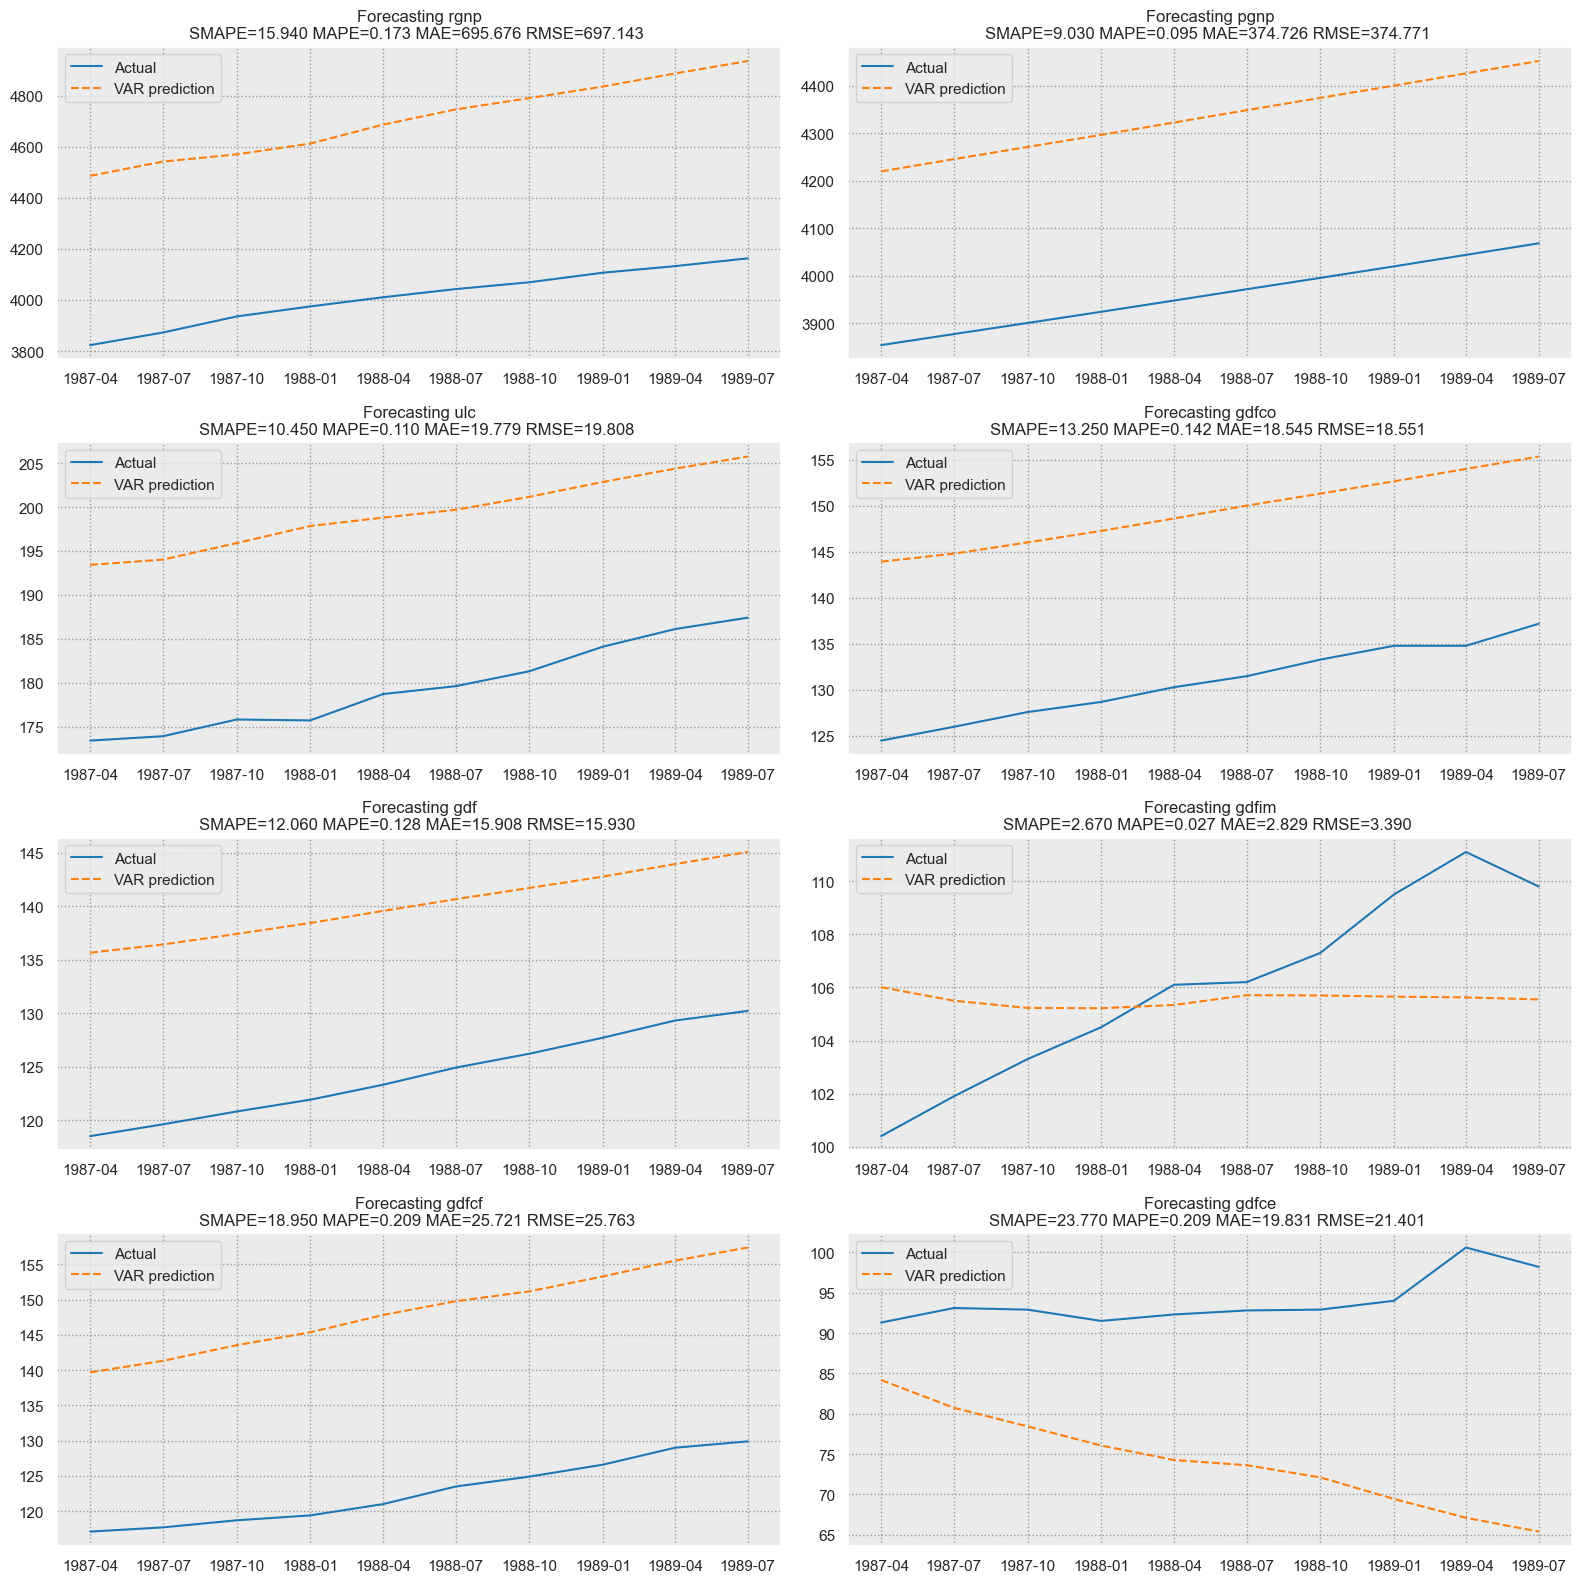

In [25]:
plot_forecast_multivariate(df[-(in_sample_size):], df_results, in_sample_size, 'VAR', col_suffix='_forecast', error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

## VARMAX

### Fit the model

In [26]:
lag_order = 4
model = VARMAX(df_train, order=(lag_order,2))
model_fitted = model.fit(maxiter=1000, disp=True)
# print(model_fitted.summary())

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [27]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

rgnp : 1.87
pgnp : 1.99
ulc : 2.08
gdfco : 2.04
gdf : 2.4
gdfim : 1.75
gdfcf : 2.22
gdfce : 1.99


### Forecast

In [28]:
# Input data for forecasting
forecast_input = df_differenced2.values[-lag_order:]
forecast_input

array([[ -5.3,   0.1,   0.8,   0.6,  -0.3,   1. ,  -1.1,  -0.4],
       [ 10.7,   0.2,   1.1,  -0.3,   0.2,   1.1,   0.3,   1. ],
       [-11.7,   0.1,  -0.8,  -1.5,   0.1,  -0.6,   0.7,   5.5],
       [  4.7,   0.1,  -0.7,   2.4,  -0.7,  -2.9,  -1.5,  -9. ]])

In [29]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=in_sample_size+out_sample_size)
df_forecast[:5]

rgnp_2d   pgnp_2d    ulc_2d  gdfco_2d    gdf_2d  gdfim_2d  gdfcf_2d  \
0   -1.747094  0.092228 -0.076057 -1.054621  0.373891 -0.355345  0.646469   
1   36.760787  0.425550 -0.665495 -0.497868 -0.630753  1.825109  0.462526   
2  -72.841167 -0.063114  1.253456 -0.110653 -0.078365 -1.536871 -1.096963   
3  118.962445  0.600948 -1.828920  0.231827  0.450220  0.285031  0.992087   
4  -60.224155  0.373796  1.676138  0.526648  0.096642  0.856531  0.386274   

   gdfce_2d  
0 -2.116247  
1  1.999451  
2 -1.410752  
3  3.039244  
4  0.889892

In [30]:
# Reverse the differencing
df_results = invert_transformation(df[-(in_sample_size):], df_forecast, second_diff=True)        
df_results.loc[:5, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

rgnp_forecast  pgnp_forecast  ulc_forecast  gdfco_forecast  gdf_forecast  \
0    4191.552906    4092.792228    188.623943      138.545379    131.473891   
1    4256.966599    4117.610005    189.182390      139.392889    132.117030   
2    4249.539125    4142.364669    190.994293      140.129746    132.681804   
3    4361.074096    4167.720280    190.977277      141.098431    133.696798   
4    4412.384912    4193.449688    192.636398      142.593763    134.808434   
5    4485.857837    4219.523486    193.411546      143.945664    135.643557   

   gdfim_forecast  gdfcf_forecast  gdfce_forecast  
0      108.144655      131.446469       93.683753  
1      108.314418      133.455464       91.166957  
2      106.947311      134.367497       87.239410  
3      105.865234      136.271617       86.351106  
4      105.639689      138.562010       86.352696  
5      106.009432      139.700131       84.170045

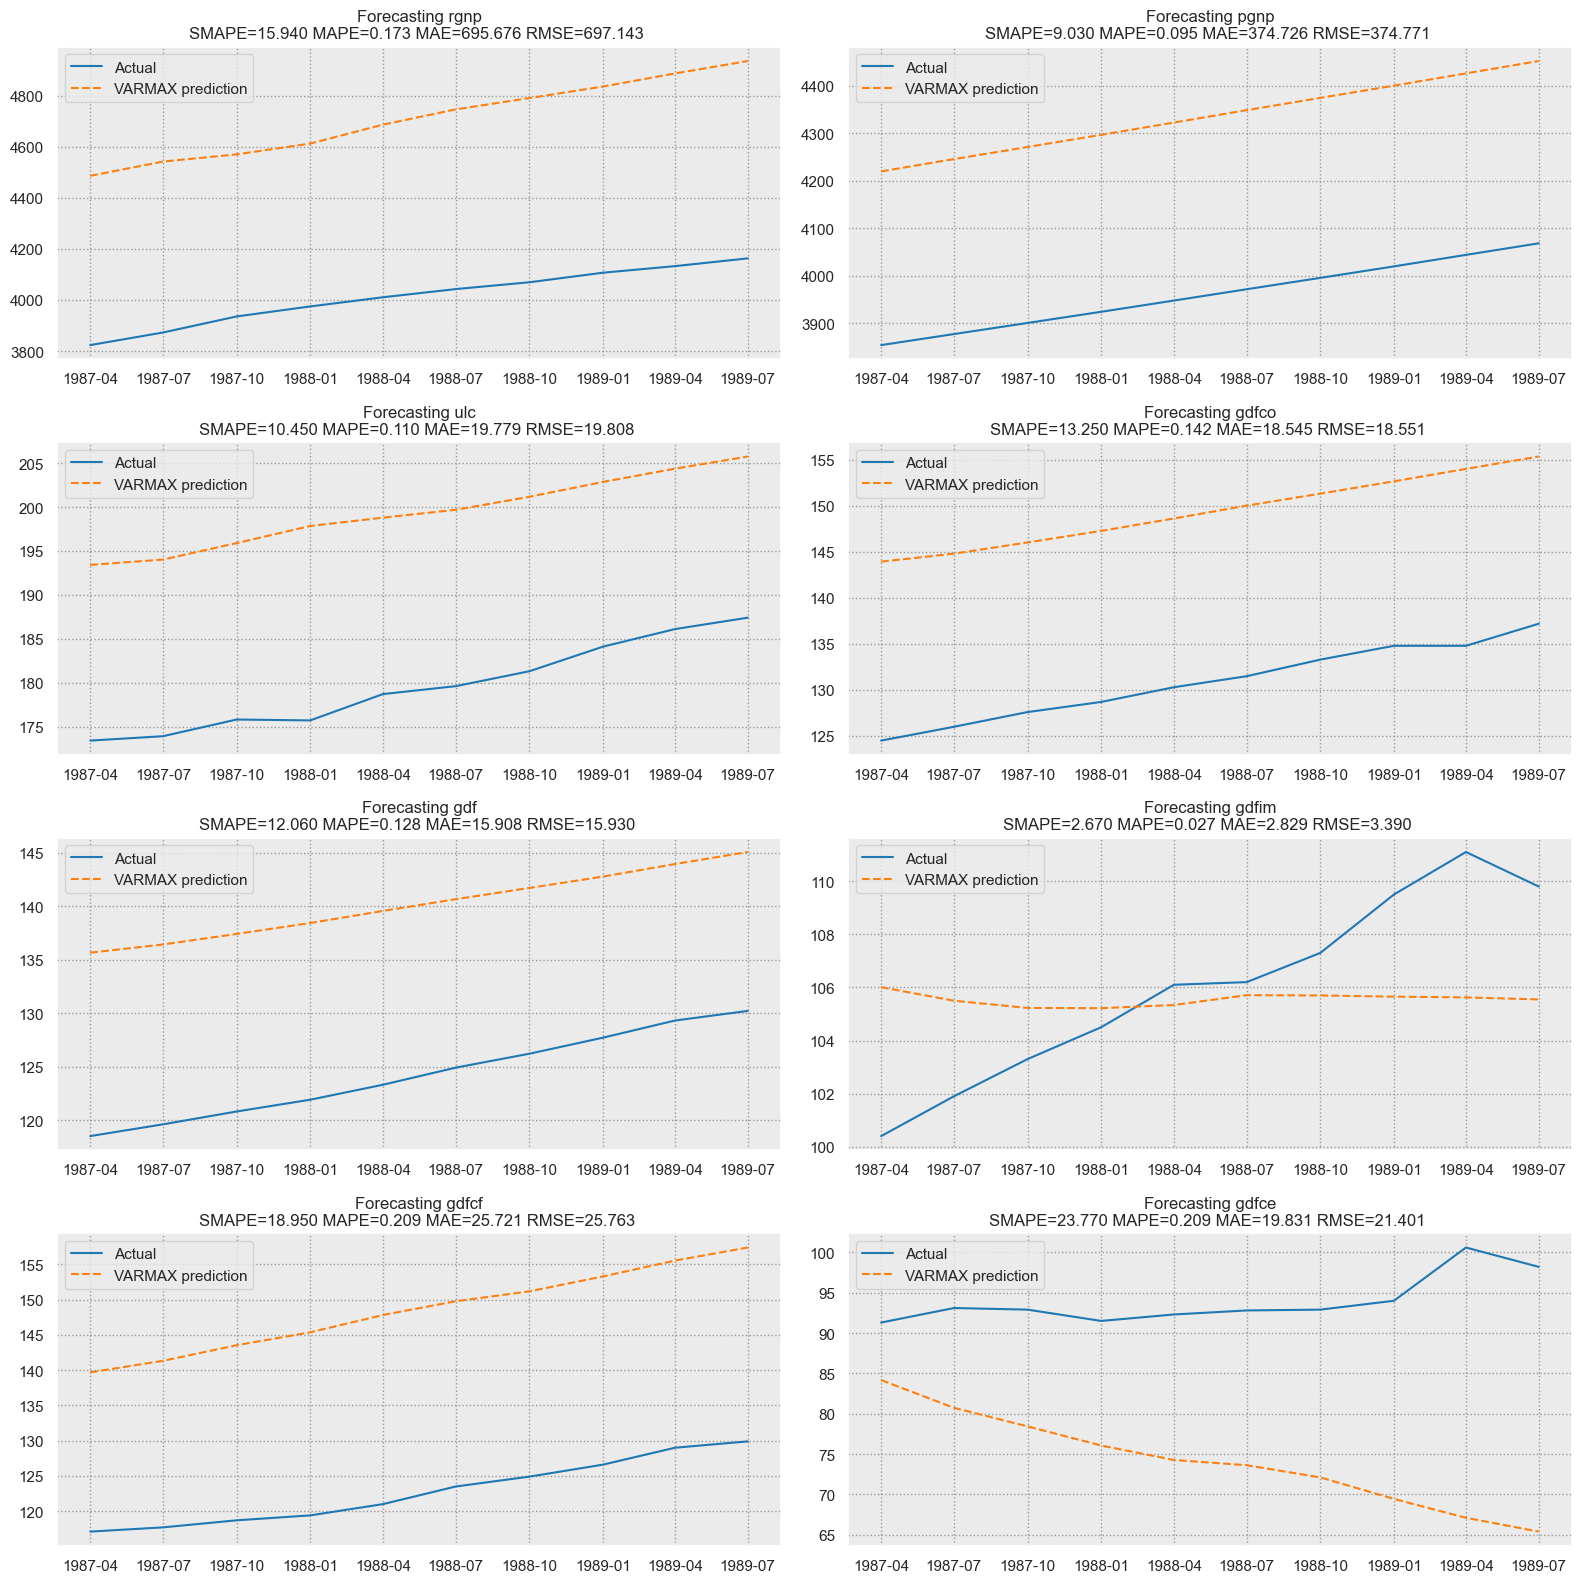

In [31]:
plot_forecast_multivariate(df[-(in_sample_size):], df_results, in_sample_size, 'VARMAX', col_suffix='_forecast', error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

In [32]:
# def plot_forecast_multivariate(data, predictions, in_sample_size, plot_fig_args, ncols=None, nrows=None):
#     if ncols is None:
#         ncols=2
#     if nrows is None:
#         nrows=len(data.columns)//ncols

#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']*nrows))
#     for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
#         plot_multi_forecast(data[col][-in_sample_size:], predictions[col+'_forecast'], in_sample_size,'VARMAX',error_name='SMAPE', error_callback=symmetric_mean_absolute_percentage_error, title=col, plot_fig_args=plot_fig_args, ax=ax)    

#     plt.tight_layout()

# Machine Learning Modeling

## Load Data

Le data set contient :
	- 187 lignes et 6 colonnes.
	- 2 valeurs manquantes, ce qui représente 0.18 % du data set.


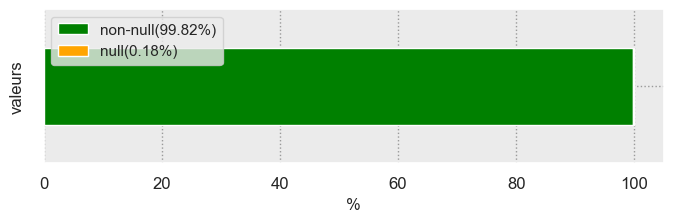

Voici les colonnes avec NaNs:


0
Column     Rose
#NaN          2
%NaN       1.07
#Not_NaN    185
%Not_NaN  98.93

Fortified  Drywhite  Sweetwhite   Red   Rose  Sparkling
date                                                               
1980-01-01       2585      1954          85   464  112.0       1686
1980-02-01       3368      2302          89   675  118.0       1591
1980-03-01       3210      3054         109   703  129.0       2304
1980-04-01       3111      2414          95   887   99.0       1712
1980-05-01       3756      2226          91  1139  116.0       1471
...               ...       ...         ...   ...    ...        ...
1995-03-01       1818      4067         188  2459   45.0       1897
1995-04-01       2262      4022         195  2618   52.0       1862
1995-05-01       2612      3937         189  2585   28.0       1670
1995-06-01       2967      4365         220  3310   40.0       1688
1995-07-01       3179      4290         274  3923   62.0       2031

[187 rows x 6 columns]

In [33]:
df = pd.read_csv('data/wine_sales.csv', parse_dates=['date'], index_col='date').sort_index()

# setting date as index
# wine.set_index('date', inplace=True)
verifier_taille(df)
df

Le data set contient :
	- 187 lignes et 6 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


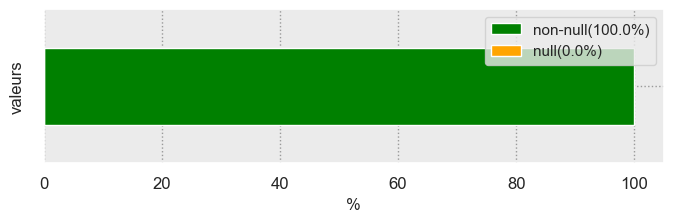

In [34]:
df['Rose'].fillna(value=df['Rose'].median(), inplace=True)
verifier_taille(df)

## EDA

<Axes: xlabel='date'>

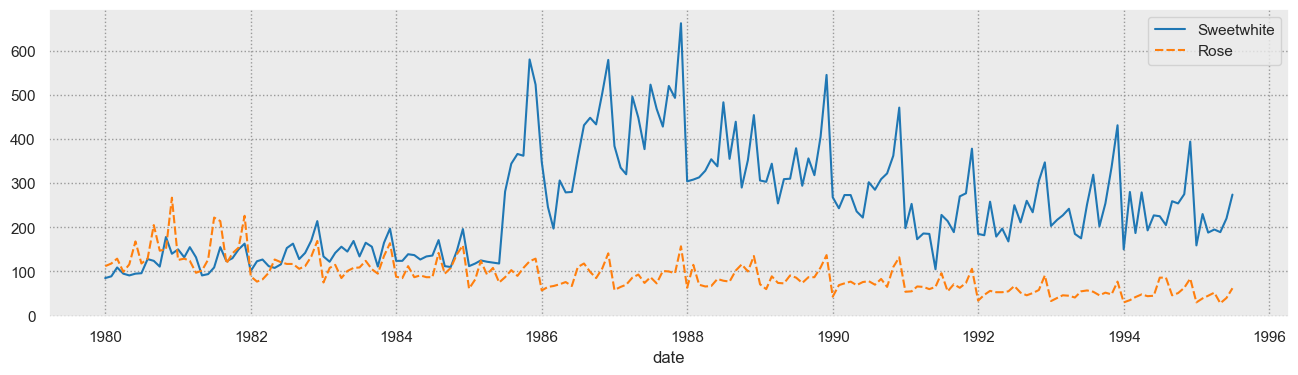

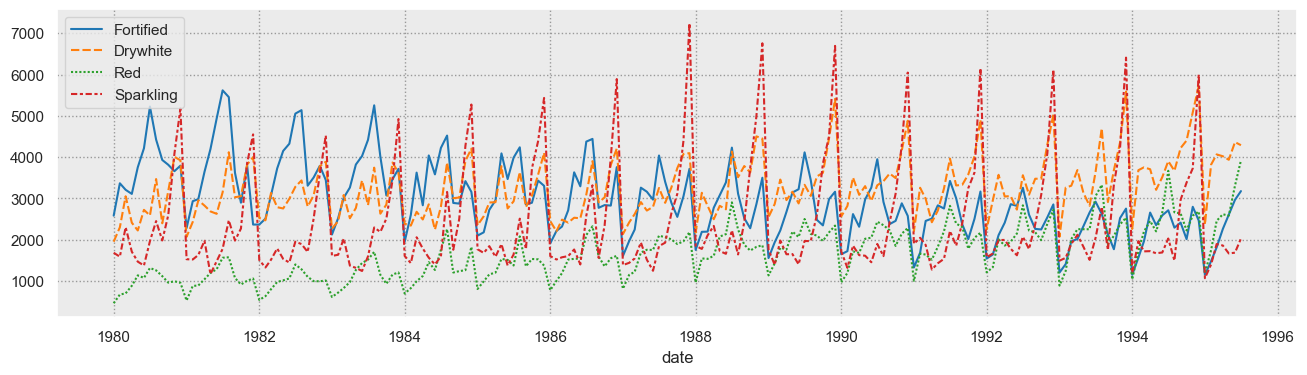

In [35]:
fig, ax = plt.subplots( dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']))
sns.lineplot(df[['Sweetwhite','Rose']], ax=ax)
fig, ax = plt.subplots( dpi=plot_fig_args['dpi'], figsize=(plot_fig_args['width'], plot_fig_args['height']))
sns.lineplot(df.drop(columns=['Sweetwhite','Rose']), ax=ax)

In [36]:
grangers_causation_matrix(df, variables = df.columns)

Fortified_x  Drywhite_x  Sweetwhite_x  Red_x  Rose_x  \
Fortified_y           1.0         0.0        0.0000    0.0     0.0   
Drywhite_y            0.0         1.0        0.0008    0.0     0.0   
Sweetwhite_y          0.0         0.0        1.0000    0.0     0.0   
Red_y                 0.0         0.0        0.0000    1.0     0.0   
Rose_y                0.0         0.0        0.0002    0.0     1.0   
Sparkling_y           0.0         0.0        0.0000    0.0     0.0   

              Sparkling_x  
Fortified_y           0.0  
Drywhite_y            0.0  
Sweetwhite_y          0.0  
Red_y                 0.0  
Rose_y                0.0  
Sparkling_y           1.0

In [37]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Fortified ::  195.09    > 83.9383   =>   True
Drywhite ::  70.62     > 60.0627   =>   True
Sweetwhite ::  37.87     > 40.1749   =>   False
Red    ::  11.49     > 24.2761   =>   False
Rose   ::  4.86      > 12.3212   =>   False
Sparkling ::  0.69      > 4.1296    =>   False


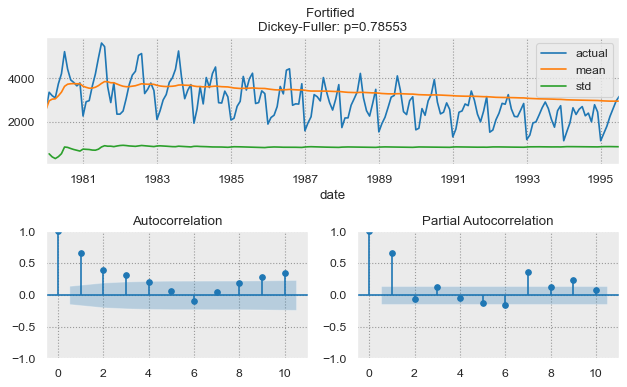

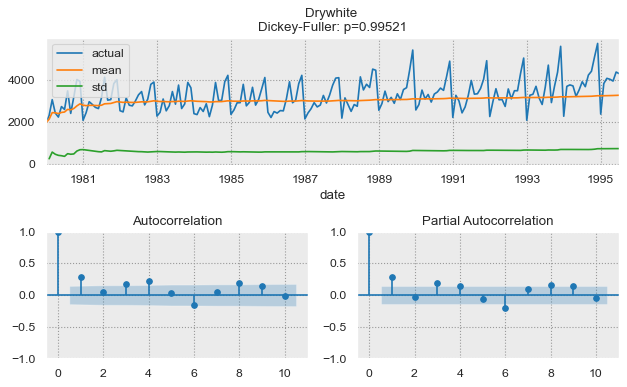

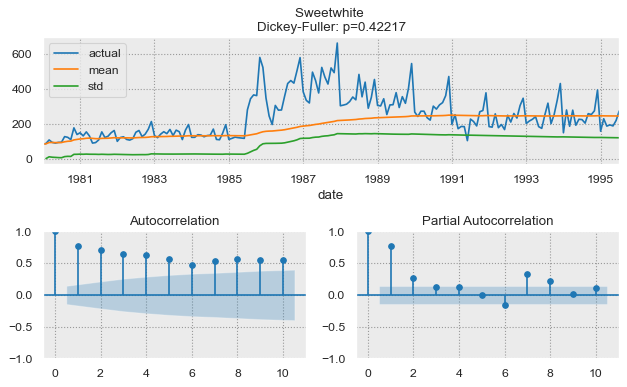

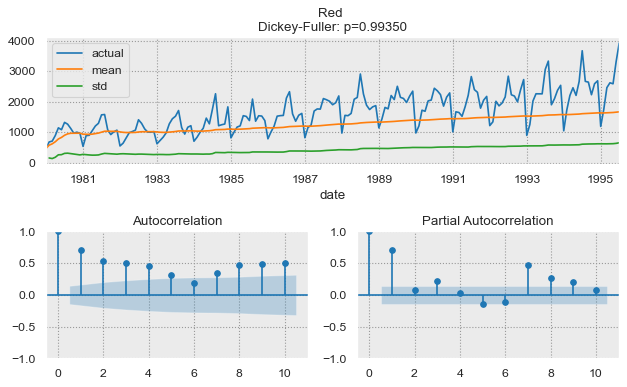

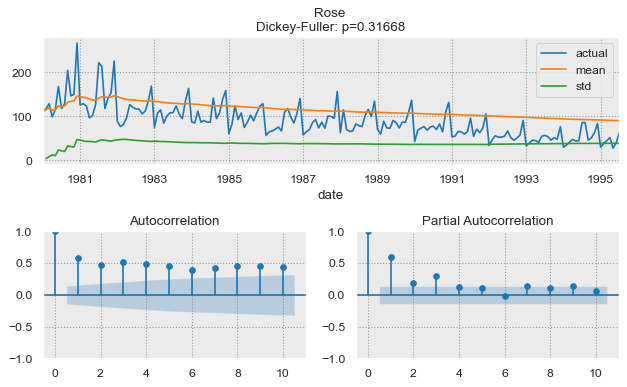

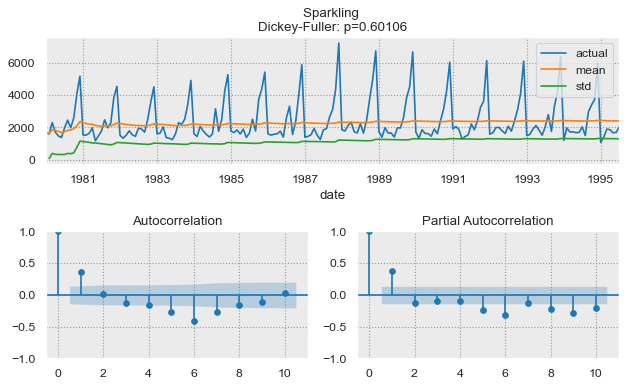

In [38]:
# ADF Test on each column
for name, column in df.iteritems():
    plot_tsa(column, name, 10, plot_tsa_fig_args)

In [39]:
# 1st difference
df_differenced = df.diff().dropna()

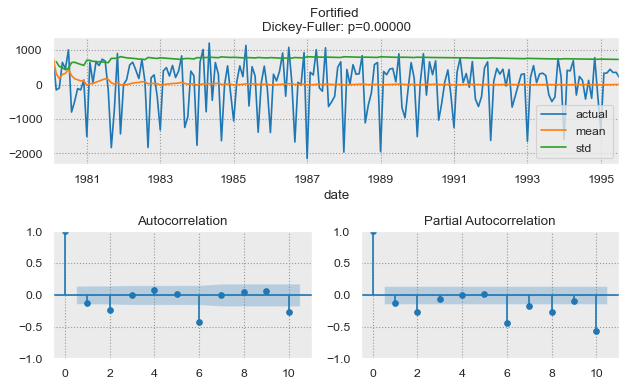

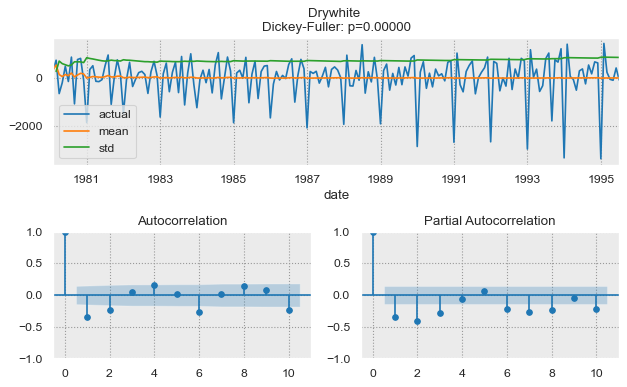

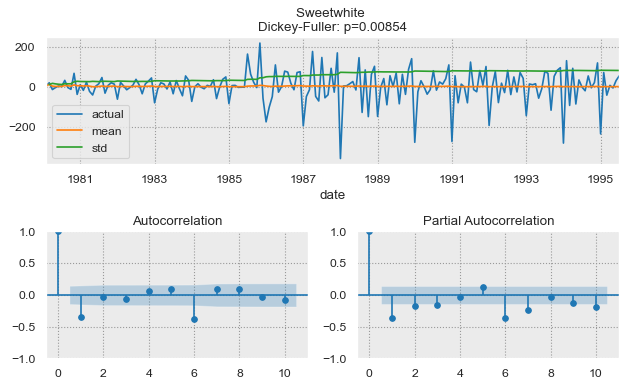

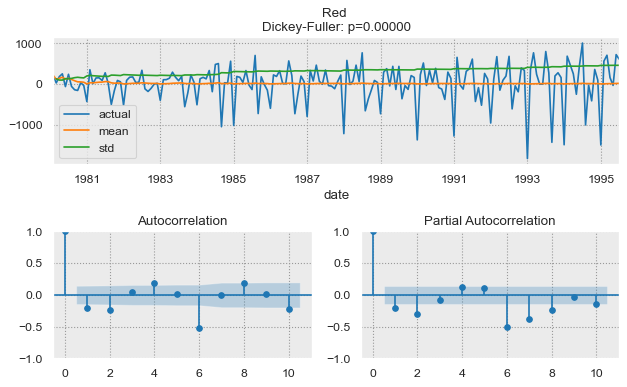

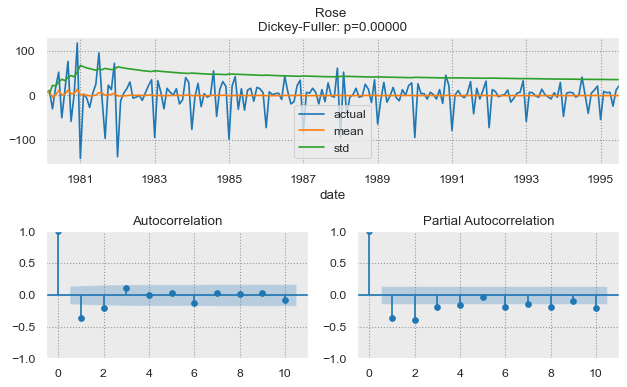

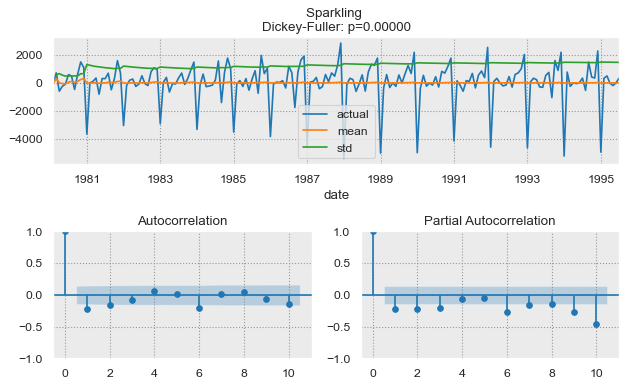

In [40]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    plot_tsa(column, name, 10, plot_tsa_fig_args)

## One Step forcast

In [41]:
# 1st difference
df_differenced = df.diff().dropna()

# create data set with lagged features using time delay embedding
n_lags=3
df_differenced_ds = []
for col in df_differenced:
    col_df = time_delay_embedding(df_differenced[col], n_lags=n_lags, horizon=1)
    df_differenced_ds.append(col_df)

# concatenating all variables
df_differenced = pd.concat(df_differenced_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = df_differenced.columns.str.contains('\(t\-')
target_variables = df_differenced.columns.str.contains('Sparkling\(t\+')

X = df_differenced.iloc[:, predictor_variables]
y = df_differenced.iloc[:, target_variables]

In [42]:
n_splits = 5
gap = 3
train_size = .7 #int(.7*len(series))
validation_size = .1 #int(.1*len(series))
test_size = .1 #int(.1*len(series)) # len(series)-(train_size+validation_size)

in_sample_size = int(test_size*len(df))

# scoring = 'neg_root_mean_squared_error'
scoring = root_mean_squared_error#symmetric_mean_absolute_percentage_error

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=validation_size, shuffle=False)
X_tr

# Reverse the differencing for y_ts
df_y = pd.DataFrame(y_ts.values, index=y_ts.index, columns=y.columns + '_1d')
y_ts = -invert_transformation(y[-in_sample_size:], df_y, second_diff=False)
y_ts = y_ts[[col for col in y_ts.columns if '_forecast' in col]]

In [43]:
def model_forecast(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)

    # getting forecasts for the test set
    return model.predict(x_test)    

def plot_model_forecast_multivariate(model, model_name, predictions, y_test, in_sample_size, difference=0, error_name=['SMAPE'], error_callback=[symmetric_mean_absolute_percentage_error], plot_fig_args=plot_fig_args):
    if difference > 0:
        # Reverse the differencing
        df_forecast = pd.DataFrame(predictions, columns=y.columns + '_1d')
        if difference == 1:
            predictions = -invert_transformation(y[-in_sample_size:], df_forecast, second_diff=False)
        if difference == 2:
            predictions = invert_transformation(y[-in_sample_size:], df_forecast, second_diff=True)
        predictions = predictions[[col for col in predictions.columns if '_forecast' in col]]

    plot_forecast_multivariate(y_test, predictions, in_sample_size, model_name, error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)    

def model_forecast_multivariate(model, model_name, x_train, y_train, x_test, y_test, in_sample_size, difference=0, error_name=['SMAPE'], error_callback=[symmetric_mean_absolute_percentage_error], plot_fig_args=plot_fig_args):
    # getting forecasts for the test set
    predictions = model_forecast(model, x_train, y_train, x_test) 
    # Plot the forecast
    plot_model_forecast_multivariate(model, model_name, predictions, y_test, in_sample_size, difference, error_name, error_callback, plot_fig_args)

def forecast_cv(model, model_name, x_train, y_train, x_test, y_test, in_sample_size, param_search, cv, cv_search_method='grid', difference=0, error_name=['SMAPE'], error_callback=[symmetric_mean_absolute_percentage_error], plot_fig_args={}):
    if cv_search_method=='random':    
        cv_search = RandomizedSearchCV(estimator=model, cv=cv, param_distributions=param_search, scoring=scoring, n_jobs=-1, verbose=2)
    else:
        cv_search = GridSearchCV(estimator=model, cv=cv, param_grid=param_search, scoring=scoring, n_jobs=-1, verbose=2)

    cv_search.fit(x_train, y_train)
    model_cv = cv_search.best_estimator_

    # getting forecasts for the test set
    predictions = model_cv.predict(x_test)

    model_forecast_multivariate(model, model_name, x_train, y_train, x_test, y_test, in_sample_size, difference, error_name, error_callback, plot_fig_args)

### Time Delay Embedding (AR)

#### Random Forest Regressor (Cross-Validated)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


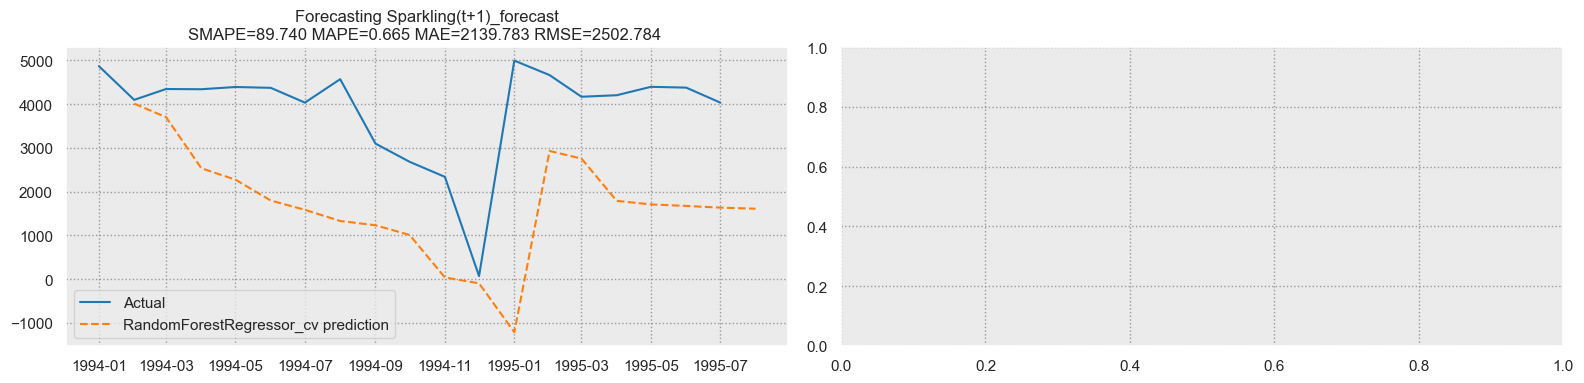

In [44]:
# fitting a random forest
model = RandomForestRegressor(n_jobs=-1)

param_search = dict(bootstrap=[False, True], min_samples_split=list(range(2,11)), random_state=list(range(5)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

forecast_cv(model, 'RandomForestRegressor_cv', X_tr, y_tr, X_ts, y_ts, in_sample_size, param_search, cv, 'grid', 1, error_name, error_callback, plot_fig_args)

#### LightGBM

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


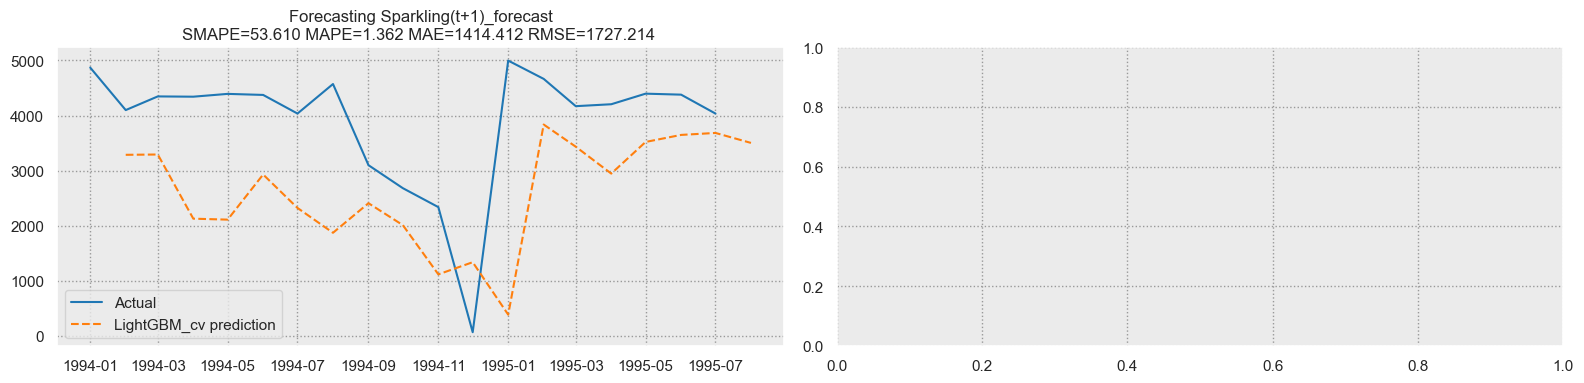

In [45]:
# fitting a LightGBM
model = lgb.LGBMRegressor(n_jobs=-1)

param_search = dict(num_leaves=list(range(2,101)), random_state=list(range(10)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

forecast_cv(model, 'LightGBM_cv', X_tr, y_tr, X_ts, y_ts, in_sample_size, param_search, cv, 'grid', 1, error_name, error_callback, plot_fig_args)

## Multi-Steps forcast

In [46]:
# 1st difference
df_differenced = df.diff().dropna().sort_index()

# create data set with lagged features using time delay embedding
n_lags=3
df_differenced_ds = []
for col in df_differenced:
    col_df = time_delay_embedding(df_differenced[col], n_lags=n_lags, horizon=3)
    df_differenced_ds.append(col_df)

# concatenating all variables
df_differenced = pd.concat(df_differenced_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = df_differenced.columns.str.contains('\(t\-')
target_variables = df_differenced.columns.str.contains('Sparkling\(t\+')

X = df_differenced.iloc[:, predictor_variables]
y = df_differenced.iloc[:, target_variables]

In [47]:
n_splits = 5
gap = 3
train_size = .7 #int(.7*len(series))
validation_size = .1 #int(.1*len(series))
test_size = .1 #int(.1*len(series)) # len(series)-(train_size+validation_size)

in_sample_size = int(test_size*len(df))

# scoring = 'neg_root_mean_squared_error'
scoring = root_mean_squared_error#symmetric_mean_absolute_percentage_error

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=validation_size, shuffle=False)
X_tr

# Reverse the differencing for y_ts
df_y = pd.DataFrame(y_ts.values, index=y_ts.index, columns=y.columns + '_1d')
y_ts = -invert_transformation(y[-in_sample_size:], df_y, second_diff=False)
y_ts = y_ts[[col for col in y_ts.columns if '_forecast' in col]]

### Time Delay Embedding (AR)

#### Direct

##### Random Forest Regressor

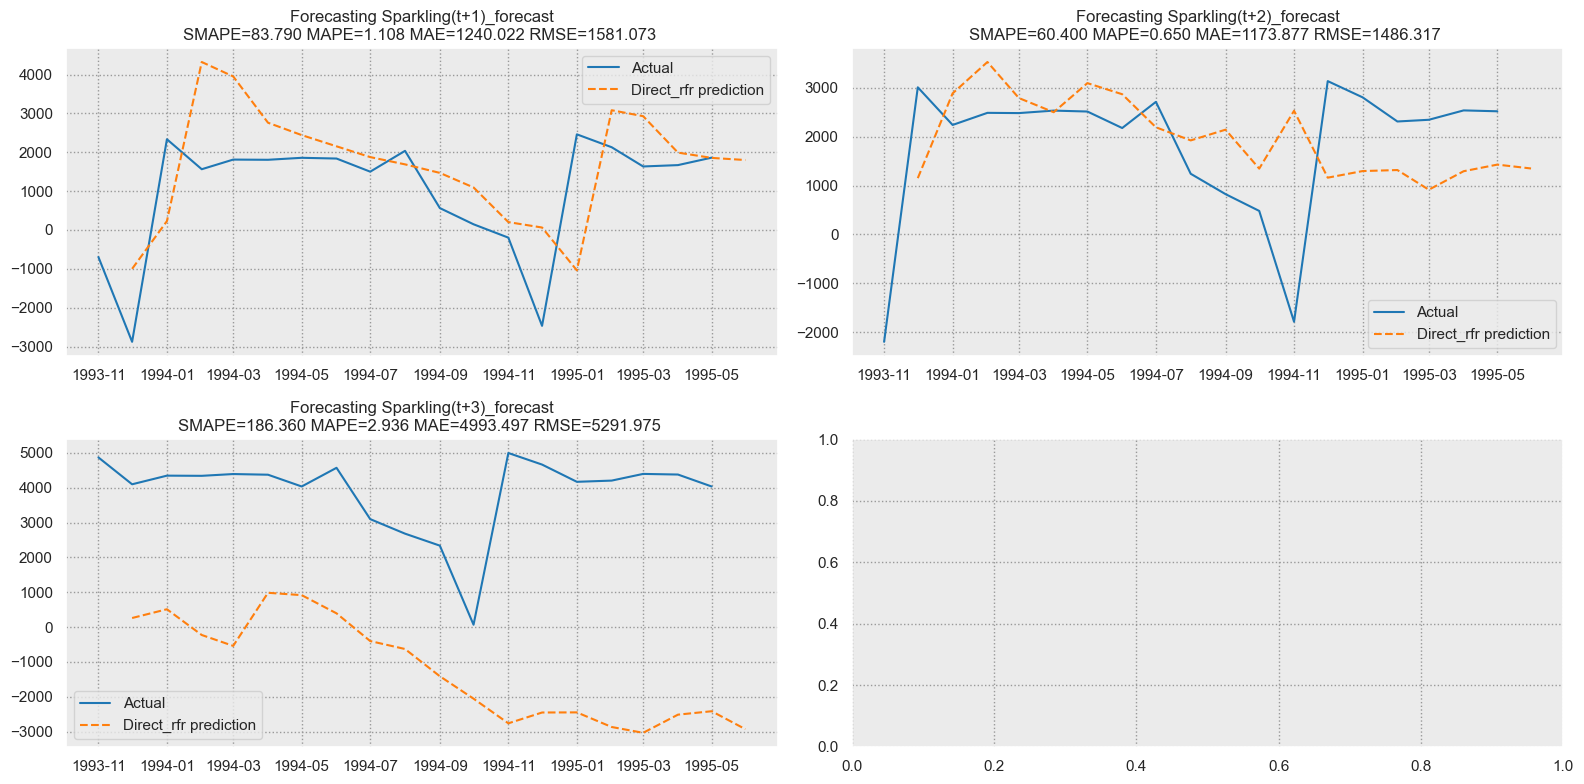

In [48]:
# fitting a RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model = MultiOutputRegressor(model)

model_forecast_multivariate(model, 'Direct_rfr', X_tr, y_tr, X_ts, y_ts, in_sample_size, difference=1, error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

##### LightGBM

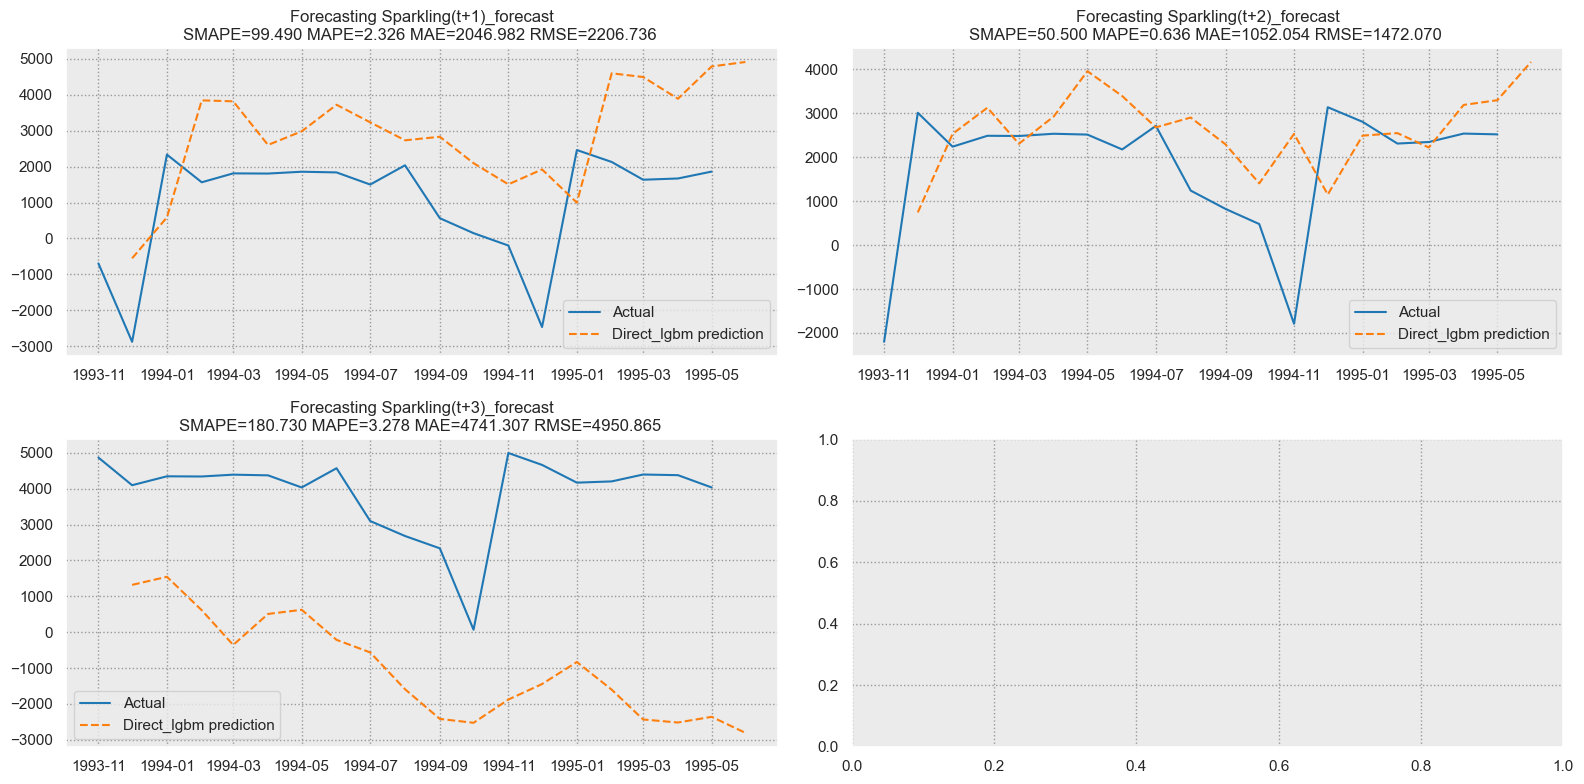

In [49]:
# fitting a LightGBM
model = lgb.LGBMRegressor(n_jobs=-1)
model = MultiOutputRegressor(model)

model_forecast_multivariate(model, 'Direct_lgbm', X_tr, y_tr, X_ts, y_ts, in_sample_size, difference=1, error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

#### DirectRecursive

##### Random Forest Regressor

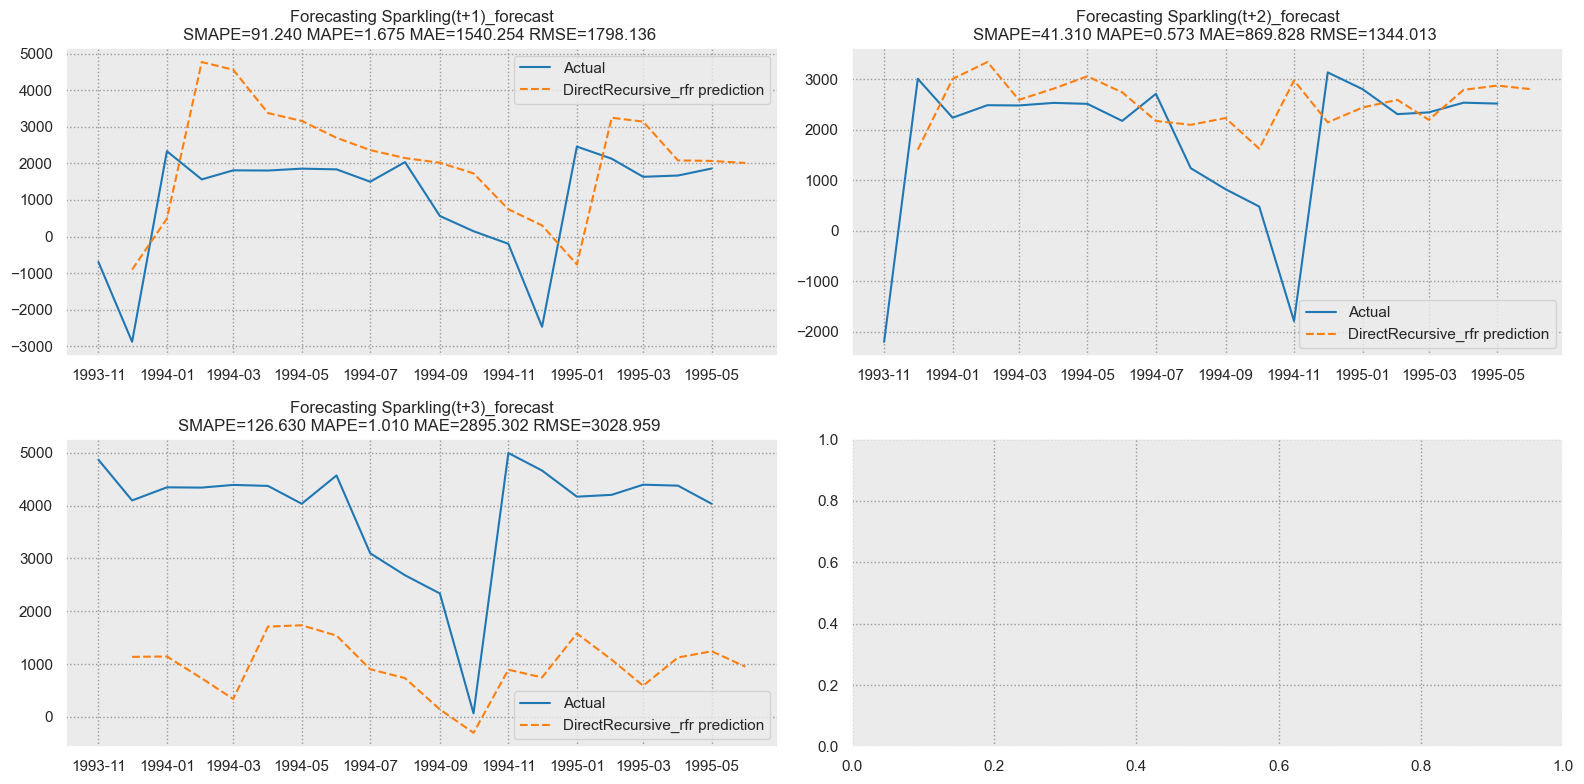

In [50]:
# fitting a RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model = RegressorChain(model, cv=n_splits)

model_forecast_multivariate(model, 'DirectRecursive_rfr', X_tr, y_tr, X_ts, y_ts, in_sample_size, difference=1, error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

##### LightGBM

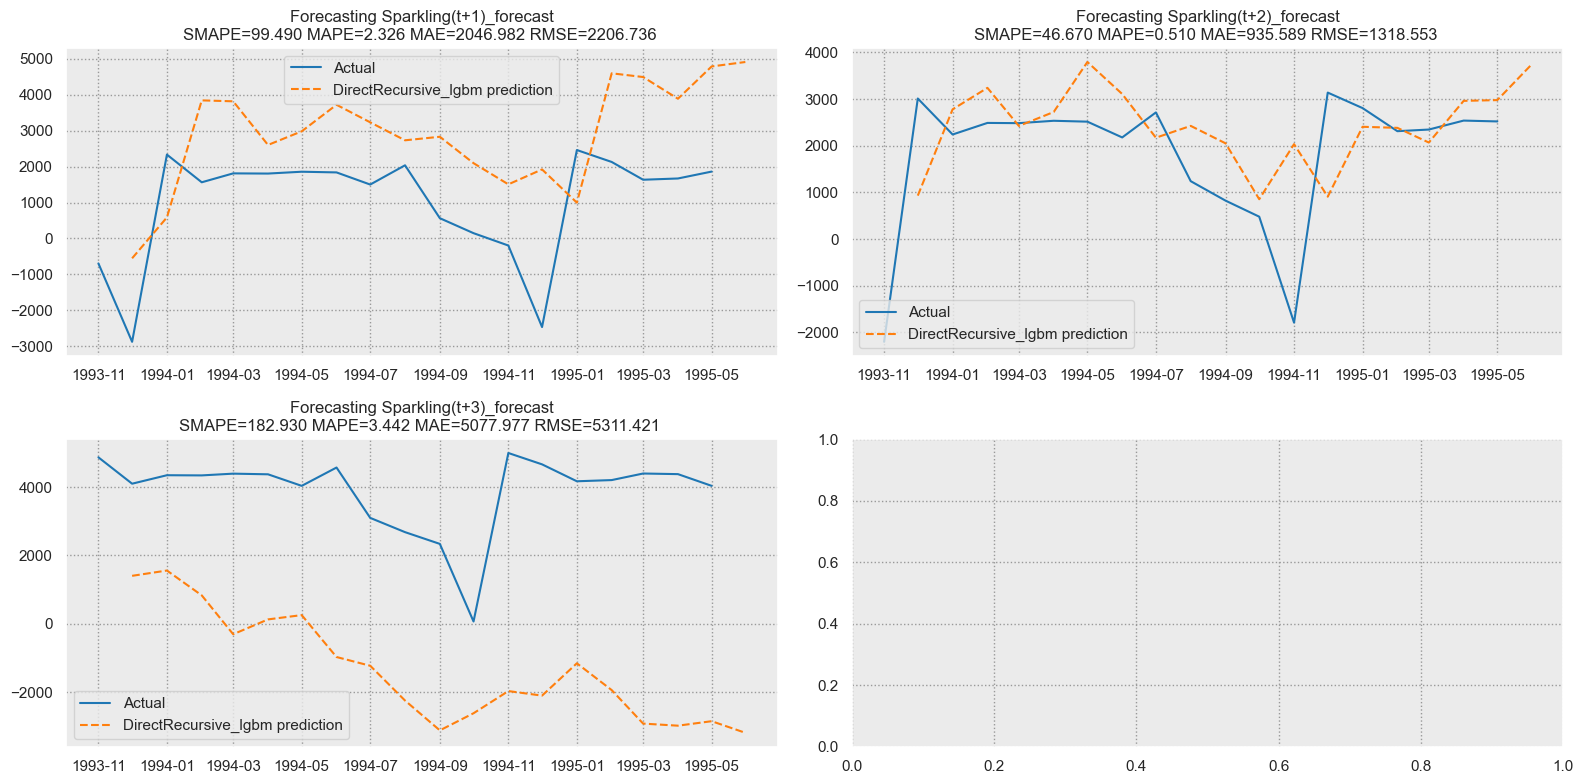

In [51]:
# fitting a RandomForestRegressor
model = lgb.LGBMRegressor(n_jobs=-1)
model = RegressorChain(model, cv=n_splits)

model_forecast_multivariate(model, 'DirectRecursive_lgbm', X_tr, y_tr, X_ts, y_ts, in_sample_size, difference=1, error_name=error_name, error_callback=error_callback, plot_fig_args=plot_fig_args)

#### Dynamic Factor Machine Learning (DFML) + DirectRecursive

##### Random Forest Regressor

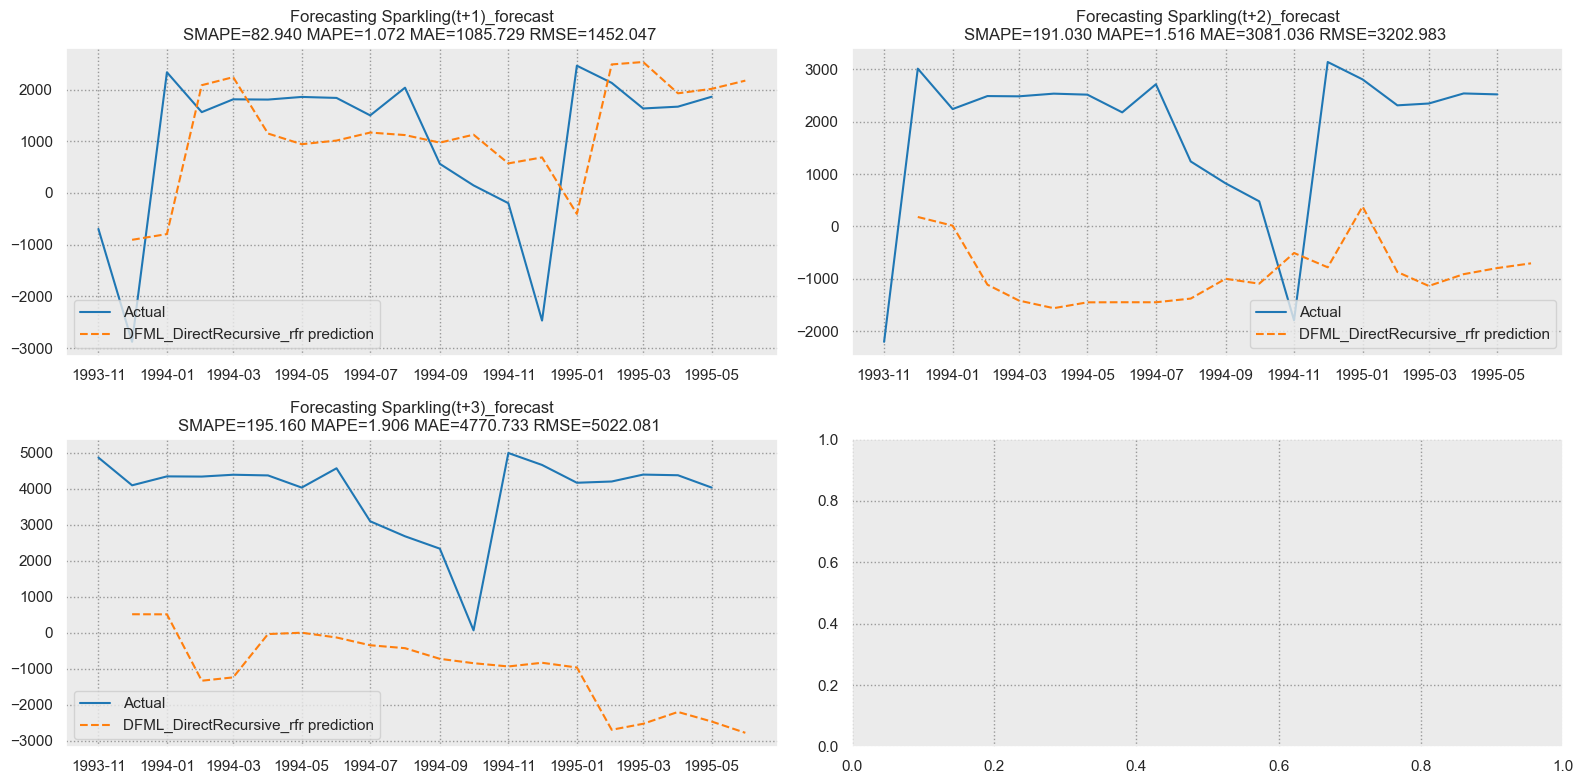

In [52]:
# combining DFML with a direct approach
model = RandomForestRegressor(n_jobs=-1)
model = RegressorChain(model, cv=n_splits)

scaler = StandardScaler()
# selecting 2 components for simplicity. This depends on the data.
pca = PCA(n_components=2)
# transforming the training target variables
Y_tr_t = scaler.fit_transform(y_tr)
Y_tr_pca = pca.fit_transform(Y_tr_t)


# getting transformed predictions and reverting to the original shape and scale
predictions = model_forecast(model, X_tr, Y_tr_pca, X_ts) 
predictions = scaler.inverse_transform(pca.inverse_transform(predictions))

# Plot the forecast
plot_model_forecast_multivariate(model, 'DFML_DirectRecursive_rfr', predictions, y_ts, in_sample_size, 1, error_name, error_callback, plot_fig_args)

##### LightGBM

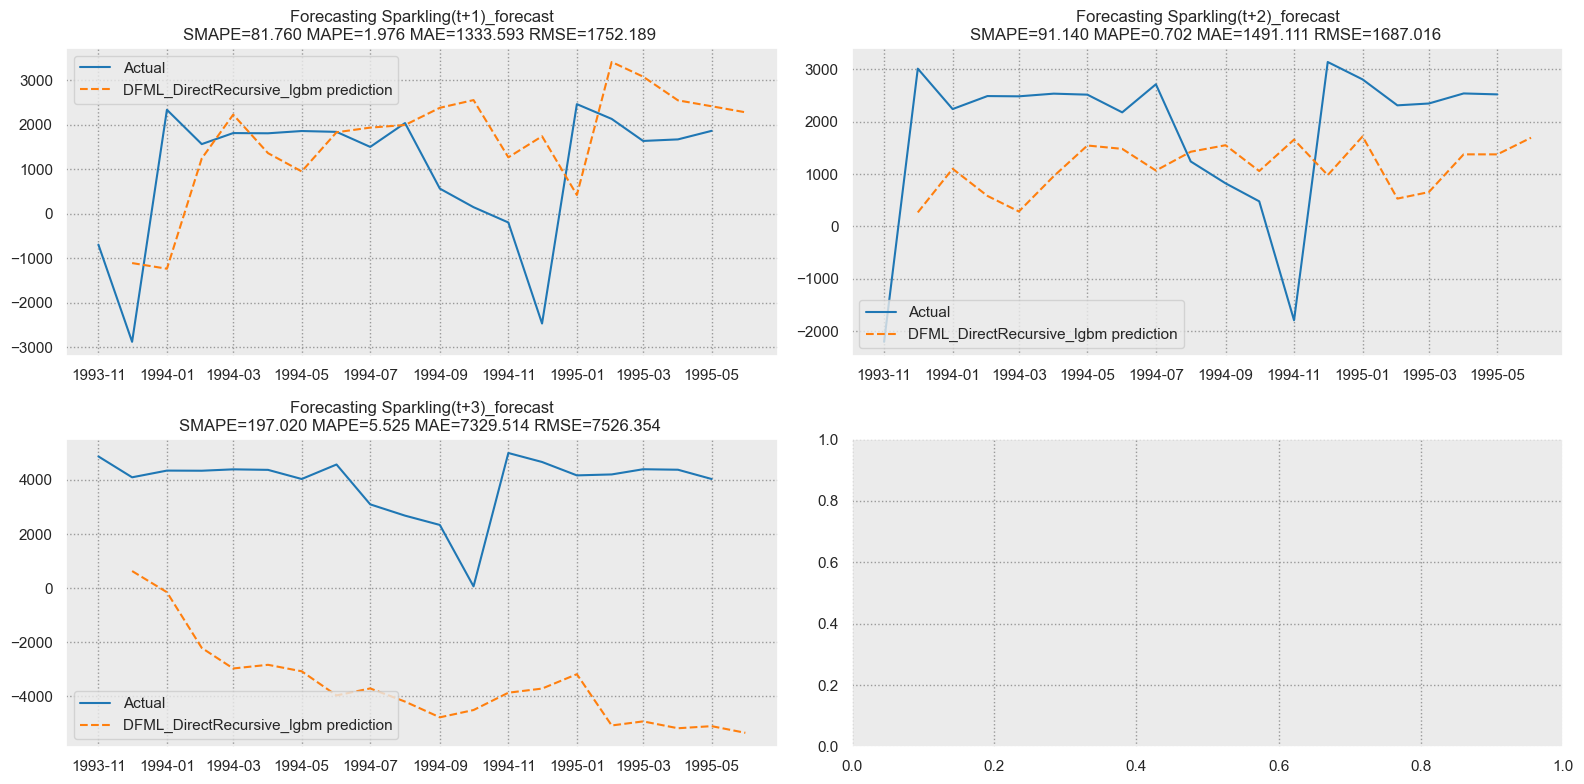

In [53]:
# combining DFML with a direct approach
model = lgb.LGBMRegressor(n_jobs=-1)
model = RegressorChain(model, cv=n_splits)

scaler = StandardScaler()
# selecting 2 components for simplicity. This depends on the data.
pca = PCA(n_components=2)
# transforming the training target variables
Y_tr_t = scaler.fit_transform(y_tr)
Y_tr_pca = pca.fit_transform(Y_tr_t)


# getting transformed predictions and reverting to the original shape and scale
predictions = model_forecast(model, X_tr, Y_tr_pca, X_ts) 
predictions = scaler.inverse_transform(pca.inverse_transform(predictions))

# Plot the forecast
plot_model_forecast_multivariate(model, 'DFML_DirectRecursive_lgbm', predictions, y_ts, in_sample_size, 1, error_name, error_callback, plot_fig_args)

#### Multi Output Cross-Validated

##### KNN

Fitting 5 folds for each of 12 candidates, totalling 60 fits


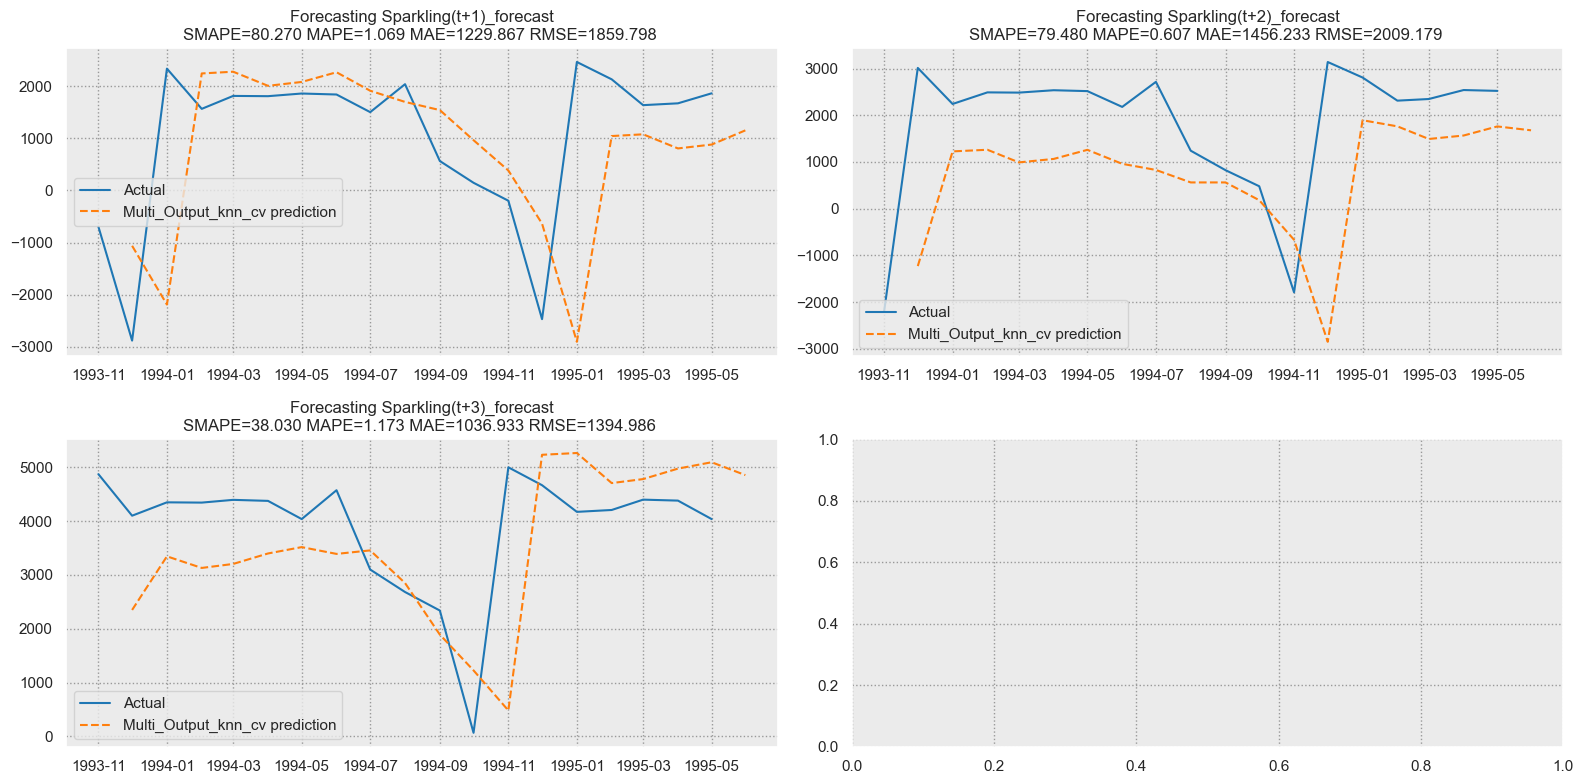

In [54]:
# knn is one of the algorithms which handles multiple targets directly
model = KNeighborsRegressor()

param_search = dict(weights=['uniform', 'distance'], n_neighbors=list(range(5,11)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

forecast_cv(model, 'Multi_Output_knn_cv', X_tr, y_tr, X_ts, y_ts, in_sample_size, param_search, cv, 'grid', 1, error_name, error_callback, plot_fig_args)

##### Random Forest Regressor

Fitting 5 folds for each of 90 candidates, totalling 450 fits


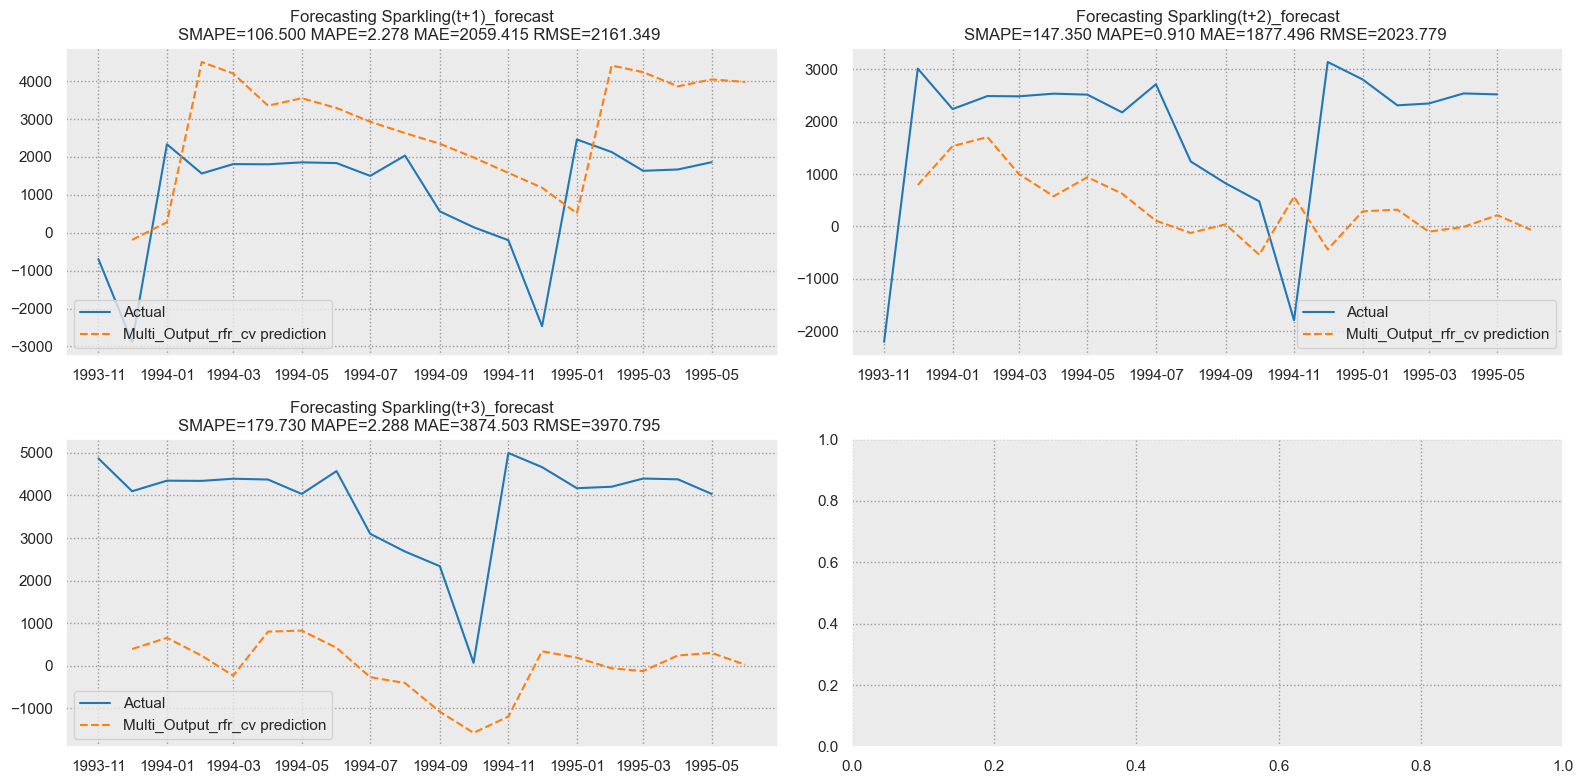

In [55]:
# fitting a random forest
model = RandomForestRegressor(n_jobs=-1)

param_search = dict(bootstrap=[False, True], min_samples_split=list(range(2,11)), random_state=list(range(5)))

cv = MonteCarloCV(n_splits=n_splits, gap=gap, train_size=train_size, test_size=validation_size)

forecast_cv(model, 'Multi_Output_rfr_cv', X_tr, y_tr, X_ts, y_ts, in_sample_size, param_search, cv, 'grid', 1, error_name, error_callback, plot_fig_args)

# Features Extraction

Le data set contient :
	- 7835 lignes et 9 colonnes.
	- 26058 valeurs manquantes, ce qui représente 36.95 % du data set.


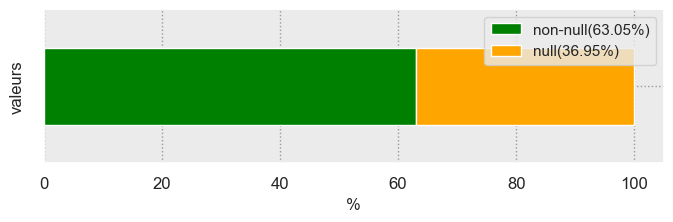

Voici les colonnes avec NaNs:


0      1      2      3      4        5      6        7  \
Column    SeaTemp   Hmax  THmax  PeakP  PeakD  Upcross    SWH  MCurDir   
#NaN         2896   2896   2896   2895   2895     2895   2895     2895   
%NaN        36.96  36.96  36.96  36.95  36.95    36.95  36.95    36.95   
#Not_NaN     4939   4939   4939   4940   4940     4940   4940     4940   
%Not_NaN    63.04  63.04  63.04  63.05  63.05    63.05  63.05    63.05   

                8  
Column    MCurSpd  
#NaN         2895  
%NaN        36.95  
#Not_NaN     4940  
%Not_NaN    63.05

PeakP       PeakD  Upcross    SWH    SeaTemp  \
time                                                                      
2022-01-01 00:00:00+00:00  4.010  162.153850    3.890  146.0  10.130833   
2022-01-01 01:00:00+00:00  4.130  161.362635    3.925  142.5  10.135000   
2022-01-01 02:00:00+00:00  4.085  158.461540    3.855  143.0  10.118333   
2022-01-01 03:00:00+00:00  5.985  191.428575    4.075  153.5  10.143333   
2022-01-01 04:00:00+00:00  5.970  221.186815    4.305  171.0  10.143333   
...                          ...         ...      ...    ...        ...   
2022-11-23 06:00:00+00:00  6.645  243.076925    4.650  169.0  10.491667   
2022-11-23 07:00:00+00:00  5.505  237.142860    4.445  154.0  10.642000   
2022-11-23 08:00:00+00:00  5.130  234.769230    4.490  165.0  10.792000   
2022-11-23 09:00:00+00:00  7.020  229.362640    4.365  156.5  10.903636   
2022-11-23 10:00:00+00:00  5.410  225.318680    4.180  164.0  10.940000   

                            Hmax  THmax     MCurDir   MCurSpd  
time                                                           
2022-01-01 00:00:00+00:00  267.5  4.675  178.051281  0.137000  
2022-01-01 01:00:00+00:00  206.0  4.080  179.882784  0.126000  
2022-01-01 02:00:00+00:00  257.5  4.535  295.648351  0.178667  
2022-01-01 03:00:00+00:00  260.0  8.170  339.413908  0.224333  
2022-01-01 04:00:00+00:00  292.0  4.995  288.586082  0.211667  
...                          ...    ...         ...       ...  
2022-11-23 06:00:00+00:00  263.5  5.415  122.974360  0.146167  
2022-11-23 07:00:00+00:00  257.5  5.410  147.868134  0.120400  
2022-11-23 08:00:00+00:00  254.0  5.855  106.652014  0.052333  
2022-11-23 09:00:00+00:00  270.5  6.295  112.210990  0.076000  
2022-11-23 10:00:00+00:00  350.0  6.290   63.223443  0.209000  

[7835 rows x 9 columns]

In [58]:
# skipping second row, setting time column as a datetime column
# dataset available here: https://github.com/vcerqueira/blog/tree/main/data
buoy = pd.read_csv('data/smart_buoy.csv', 
                   skiprows=[1], 
                   parse_dates=['time'])

# setting time as index
buoy.set_index('time', inplace=True)
# resampling to hourly data
buoy = buoy.resample('H').mean()
# simplifying column names
buoy.columns = [
    'PeakP', 'PeakD', 'Upcross',
    'SWH', 'SeaTemp', 'Hmax', 'THmax',
    'MCurDir', 'MCurSpd'
]

verifier_taille(buoy)
buoy

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape


target_var = 'SWH'

colnames = buoy.columns.tolist()

# create data set with lagged features using time delay embedding
buoy_ds = []
for col in buoy:
    col_df = time_delay_embedding(buoy[col], n_lags=24, horizon=12)
    buoy_ds.append(col_df)

# concatenating all variables
buoy_df = pd.concat(buoy_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = buoy_df.columns.str.contains('\(t\-')
target_variables = buoy_df.columns.str.contains(f'{target_var}\(t\+')
X = buoy_df.iloc[:, predictor_variables]
Y = buoy_df.iloc[:, target_variables]

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

## Univariate Features Extraction

In [63]:
SUMMARY_STATS = {
    'mean': np.mean,
    'std': np.std,
}

univariate_features = {}
# for each column in the data
for col in buoy_df.columns.to_list():
    # get lags for that column
    X_col = X.iloc[:, X.columns.str.startswith(col)]

    # for each summary stat
    for feat, func in SUMMARY_STATS.items():
        # compute that stat along the rows
        univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)

# concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)
univariate_features_df

PeakP(t-23)_mean  PeakP(t-23)_std  \
time                                                           
2022-01-02 00:00:00+00:00             4.010              0.0   
2022-01-02 01:00:00+00:00             4.130              0.0   
2022-01-02 02:00:00+00:00             4.085              0.0   
2022-01-02 03:00:00+00:00             5.985              0.0   
2022-01-02 04:00:00+00:00             5.970              0.0   
...                                     ...              ...   
2022-11-22 19:00:00+00:00             6.785              0.0   
2022-11-22 20:00:00+00:00             5.645              0.0   
2022-11-22 21:00:00+00:00             5.410              0.0   
2022-11-22 22:00:00+00:00             7.570              0.0   
2022-11-22 23:00:00+00:00             7.450              0.0   

                           PeakP(t-22)_mean  PeakP(t-22)_std  \
time                                                           
2022-01-02 00:00:00+00:00             4.130              0.0   
2022-01-02 01:00:00+00:00             4.085              0.0   
2022-01-02 02:00:00+00:00             5.985              0.0   
2022-01-02 03:00:00+00:00             5.970              0.0   
2022-01-02 04:00:00+00:00             7.180              0.0   
...                                     ...              ...   
2022-11-22 19:00:00+00:00             5.645              0.0   
2022-11-22 20:00:00+00:00             5.410              0.0   
2022-11-22 21:00:00+00:00             7.570              0.0   
2022-11-22 22:00:00+00:00             7.450              0.0   
2022-11-22 23:00:00+00:00            10.715              0.0   

                           PeakP(t-21)_mean  PeakP(t-21)_std  \
time                                                           
2022-01-02 00:00:00+00:00             4.085              0.0   
2022-01-02 01:00:00+00:00             5.985              0.0   
2022-01-02 02:00:00+00:00             5.970              0.0   
2022-01-02 03:00:00+00:00             7.180              0.0   
2022-01-02 04:00:00+00:00             8.515              0.0   
...                                     ...              ...   
2022-11-22 19:00:00+00:00             5.410              0.0   
2022-11-22 20:00:00+00:00             7.570              0.0   
2022-11-22 21:00:00+00:00             7.450              0.0   
2022-11-22 22:00:00+00:00            10.715              0.0   
2022-11-22 23:00:00+00:00             7.800              0.0   

                           PeakP(t-20)_mean  PeakP(t-20)_std  \
time                                                           
2022-01-02 00:00:00+00:00             5.985              0.0   
2022-01-02 01:00:00+00:00             5.970              0.0   
2022-01-02 02:00:00+00:00             7.180              0.0   
2022-01-02 03:00:00+00:00             8.515              0.0   
2022-01-02 04:00:00+00:00             7.380              0.0   
...                                     ...              ...   
2022-11-22 19:00:00+00:00             7.570              0.0   
2022-11-22 20:00:00+00:00             7.450              0.0   
2022-11-22 21:00:00+00:00            10.715              0.0   
2022-11-22 22:00:00+00:00             7.800              0.0   
2022-11-22 23:00:00+00:00             8.000              0.0   

                           PeakP(t-19)_mean  PeakP(t-19)_std  \
time                                                           
2022-01-02 00:00:00+00:00             5.970              0.0   
2022-01-02 01:00:00+00:00             7.180              0.0   
2022-01-02 02:00:00+00:00             8.515              0.0   
2022-01-02 03:00:00+00:00             7.380              0.0   
2022-01-02 04:00:00+00:00             7.380              0.0   
...                                     ...              ...   
2022-11-22 19:00:00+00:00             7.450              0.0   
2022-11-22 20:00:00+00:00            10.715              0.0   
2022-11-22 21:00:00+00:00             7.800            

## Bivariate Features Extraction

In [64]:
import itertools

import pandas as pd

from scipy.spatial.distance import jensenshannon
from scipy import signal
from scipy.special import rel_entr

from my_functions.tsa.feature_extraction import covariance, co_integration

BIVARIATE_SUMMARY_STATS = {
    'covariance': covariance,
    'co_integration': co_integration,
    'js_div': jensenshannon,
}

BIVARIATE_TRANSFORMATIONS = {
    'corr': signal.correlate,
    'conv': signal.convolve,
    'rel_entr': rel_entr,
}

# get all pairs of variables
col_combs = list(itertools.combinations(df_differenced.columns.to_list(), 2))

bivariate_features = []
# for each row
for i, _ in X.iterrows():
    # feature set in the i-th time-step
    feature_set_i = {}
    for col1, col2 in col_combs:
        # features for pair of columns col1, col2

        # getting the i-th instance for each column
        x1 = X.loc[i, X.columns.str.startswith(col1)]
        x2 = X.loc[i, X.columns.str.startswith(col2)]

        # compute each summary stat
        for feat, func in BIVARIATE_SUMMARY_STATS.items():
            feature_set_i[f'{col1}|{col2}_{feat}'] = func(x1, x2)

        # for each transformation
        for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():

            # apply transformation
            xt = t_func(x1, x2)

            # compute summary stat
            for feat, s_func in BIVARIATE_SUMMARY_STATS.items():
                feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)

    bivariate_features.append(feature_set_i)

bivariate_features_df = pd.DataFrame(bivariate_features, index=X.index)
bivariate_features_df

ValueError: zero-size array to reduction operation maximum which has no identity

# Ensemble Forecasting

In [65]:
import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from pmdarima.datasets import load_ausbeer  # GPL>=2 licence

from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    AutoTheta,
    AutoETS,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

# https://github.com/vcerqueira/blog/tree/main/src/
from my_functions.tsa.plot.forecasts import train_test_yhat_plot
from my_functions.tsa.plot.barplots import err_barplot

# quarterly data
PERIOD = 4
# forecasting the final 3 years of data
TEST_SIZE = 12

# loading the beer time series
series = load_ausbeer(as_series=True).dropna()
series.index = pd.date_range(start='1956Q1', end='2008Q3', freq='QS')

# train/test split
train, test = train_test_split(series, test_size=TEST_SIZE, shuffle=False)

# transforming the train data to the required format for statsforecast
train_df = train.reset_index()
train_df.columns = ['ds', 'y']
train_df['unique_id'] = '1'

# setting up the models
models = [
    AutoARIMA(season_length=PERIOD),
    HoltWinters(season_length=PERIOD),
    SeasonalNaive(season_length=PERIOD),
    AutoTheta(season_length=PERIOD),
    DOT(season_length=PERIOD),
    AutoETS(season_length=PERIOD),
]

sf = StatsForecast(
    df=train_df,
    models=models,
    freq='Q',
    n_jobs=1,
    fallback_model=SeasonalNaive(season_length=PERIOD)
)

# training the models
sf.fit(train_df)

# forecasting
forecasts = sf.predict(h=TEST_SIZE)
forecasts = forecasts.reset_index(drop=True).set_index('ds')

# averaging the forecasts to make the ensemble predictions
forecasts['Ensemble'] = forecasts.mean(axis=1)

In [66]:
forecasts

AutoARIMA  HoltWinters  SeasonalNaive   AutoTheta  \
ds                                                               
2005-09-30  475.536316   479.699585          454.0  507.843079   
2005-12-31  423.840637   420.329071          416.0  437.718872   
2006-03-31  390.136383   385.594208          403.0  388.765961   
2006-06-30  407.294739   401.986603          408.0  404.528198   
2006-09-30  478.902374   477.737823          454.0  509.977570   
2006-12-31  422.372650   418.506897          416.0  439.556702   
2007-03-31  388.668427   383.901703          403.0  390.396545   
2007-06-30  405.826782   400.414551          408.0  406.223114   
2007-09-30  477.434387   476.277649          454.0  512.112061   
2007-12-31  420.904694   417.150635          416.0  441.394531   
2008-03-31  387.200439   382.641968          403.0  392.027130   
2008-06-30  404.358795   399.244446          408.0  407.918060   

            DynamicOptimizedTheta     AutoETS    Ensemble  
ds                                                         
2005-09-30             507.453827  483.476532  484.668213  
2005-12-31             437.286346  421.817078  426.165314  
2006-03-31             388.292145  386.966217  390.459137  
2006-06-30             403.938324  402.667542  404.735931  
2006-09-30             509.107483  480.647705  485.062134  
2006-12-31             438.694122  419.345428  425.745972  
2007-03-31             389.527222  384.695435  390.031525  
2007-06-30             405.207977  400.301147  404.328949  
2007-09-30             510.688934  477.818878  484.721954  
2007-12-31             440.041046  416.873749  425.394135  
2008-03-31             390.709442  382.424652  389.667267  
2008-06-30             406.423828  397.934753  403.979980